# Evaluation of Synthetic Data Generation for Imbalanced Classification

This notebook provides a complete evaluation of synthetic data generation methods (CTGAN, TVAE, DDPM, NFlow) for addressing class imbalance in the Mammographic Mass dataset. The analysis is structured around two complementary evaluation dimensions:

- Downstream ML Performance (Utility)

     **Metrics:** F1-score, ROC-AUC, Precision, Recall (minority class)

- Synthetic Data Quality (Fidelity & Privacy)

     **Metrics :** Statistical Fidelity (ImprovedPrecision, ImprovedRecall, Density, Coverage), Privacy (Authenticity)

## Setup & Configuration

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import glob
from matplotlib.patches import Patch
import re
from tqdm.notebook import tqdm
import warnings

from sklearn.preprocessing import MinMaxScaler

from pymdma.tabular.measures.synthesis_val import (
    ImprovedPrecision,
    ImprovedRecall,
    Density,
    Coverage,
    Authenticity,
)

from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

warnings.filterwarnings("ignore")

In [80]:
import sys
from pathlib import Path

sys.path.append(str(Path("../src").resolve()))
from config import get_config

config = get_config()

RESULTS_PATH = Path("../results/tables/")
FIGURES_PATH = Path("../results/figures/")
PROCESSED_PATH = Path("../data/processed/")
SYNTHETIC_PATH_BASE = Path("../data/synthetic/")

FIGURES_PATH.mkdir(exist_ok=True, parents=True)

TARGET_FEATURE = "Severity"

IMBALANCE_RATIOS = config.experiment.imbalance_ratios
N_REPETITIONS = config.experiment.n_repetitions

GENERATORS = config.models.generators
SYNTHETIC_MODELS = config.models.generators
MODELS_TO_ANALYZE = ['baseline'] + config.models.generators

PALETTE = config.visualization.color_palette

MODEL_COLORS = {model: color for model, color in zip(MODELS_TO_ANALYZE, sns.color_palette(PALETTE, len(MODELS_TO_ANALYZE)))}

palette = sns.color_palette("colorblind", n_colors=len(GENERATORS))

GENERATOR_STYLES = {}
for gen in GENERATORS:
    gen_upper = gen.upper()
    style = config.visualization.generator_styles.__dict__[gen]
    GENERATOR_STYLES[gen_upper] = {
        "color": style.color,
        "marker": style.marker,
        "linestyle": style.linestyle
    }


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (config.visualization.figure_size.width, config.visualization.figure_size.height)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'

print(f"Models to analyze: {MODELS_TO_ANALYZE}")

Models to analyze: ['baseline', 'ddpm', 'nflow', 'ctgan', 'tvae']


## Data Loading & Preparation

In [81]:
def get_latest_results_folder(results_path):
    """Get the most recent timestamped results folder"""
    run_folders = sorted(results_path.glob("run_*"))
    
    if not run_folders:
        # Fallback to checking for files in the root tables folder
        if (results_path / "summary_experiment_results.csv").exists():
            print("Warning: Using results from root folder (no timestamped runs found)")
            return results_path
        else:
            raise FileNotFoundError(f"No timestamped run folders found in {results_path}")
    
    latest_folder = run_folders[-1]
    print(f"Loading results from: {latest_folder.name}")
    return latest_folder

def get_latest_synthetic_folder(synthetic_path_base):
    """Get the most recent timestamped synthetic data folder"""
    run_folders = sorted(synthetic_path_base.glob("run_*"))
    
    if not run_folders:
        # Fallback to root synthetic folder
        print("Warning: Using synthetic data from root folder (no timestamped runs found)")
        return synthetic_path_base
    
    latest_folder = run_folders[-1]
    print(f"Loading synthetic data from: {latest_folder.name}")
    return latest_folder

try:
    latest_results_folder = get_latest_results_folder(RESULTS_PATH)
    SYNTHETIC_PATH = get_latest_synthetic_folder(SYNTHETIC_PATH_BASE)
    
    summary_df = pd.read_csv(latest_results_folder / "summary_experiment_results.csv")
    detailed_df = pd.read_csv(latest_results_folder / "detailed_experiment_results.csv")
    print("Results files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: Results files not found. Please run the experiment script first.")
    print(f"Expected files in: {RESULTS_PATH}")
    raise e

print(f"Total experimental conditions: {len(summary_df)}")
print(f"Total individual runs: {len(detailed_df)}")
print(f"\nDataset types: {summary_df['dataset_type'].unique()}")
print(f"Models tested: {summary_df['model'].unique()}")
print(f"Imbalance ratios: {sorted(summary_df['imbalance_ratio'].unique())}")

n_repetitions = detailed_df['repetition_id'].nunique()
print(f"Number of repetitions found: {n_repetitions}")

Loading results from: run_20241029_143227
Loading synthetic data from: run_20241029_143227
Results files loaded successfully!
Total experimental conditions: 60
Total individual runs: 180

Dataset types: ['control' 'imbalanced']
Models tested: ['baseline' 'ctgan' 'ddpm' 'nflow' 'tvae']
Imbalance ratios: ['100:1', '10:1', '1:1', '20:1', '50:1', '5:1']
Number of repetitions found: 3


In [82]:
def extract_ir_numeric(ir_str):
    return int(ir_str.split(':')[0])

summary_df['ir_numeric'] = summary_df['imbalance_ratio'].apply(extract_ir_numeric)
detailed_df['ir_numeric'] = detailed_df['imbalance_ratio'].apply(extract_ir_numeric)

summary_df = summary_df.sort_values(['dataset_type', 'ir_numeric', 'model'])
detailed_df = detailed_df.sort_values(['dataset_type', 'ir_numeric', 'model', 'repetition_id'])

print("\nData Structure Check (first 10 rows)")
print(summary_df[['dataset_type', 'imbalance_ratio', 'model', 'f1_minority_mean', 'f1_minority_std']].head(10))

print("\nData Statistics")
print(f"Models in summary: {summary_df['model'].unique()}")
print(f"IR values: {sorted(summary_df['ir_numeric'].unique())}")


Data Structure Check (first 10 rows)
   dataset_type imbalance_ratio     model  f1_minority_mean  f1_minority_std
10      control             1:1  baseline          0.799291         0.006681
11      control             1:1     ctgan          0.797226         0.005244
12      control             1:1      ddpm          0.790866         0.002412
13      control             1:1     nflow          0.800629         0.009883
14      control             1:1      tvae          0.792397         0.004302
25      control             5:1  baseline          0.784051         0.019504
26      control             5:1     ctgan          0.782008         0.018996
27      control             5:1      ddpm          0.791068         0.026921
28      control             5:1     nflow          0.771924         0.018948
29      control             5:1      tvae          0.793115         0.017612

Data Statistics
Models in summary: ['baseline' 'ctgan' 'ddpm' 'nflow' 'tvae']
IR values: [np.int64(1), np.int64(5)

# Part 1: Downstream ML Performance Analysis

This section evaluates how well synthetic data methods improve classifier performance compared to the baseline. We focus on practical utility: F1-score, ROC-AUC, Precision, and Recall.

## 1.1 Overall Performance Comparison

Visualizing the impact of multiple runs via standard deviation error bands.

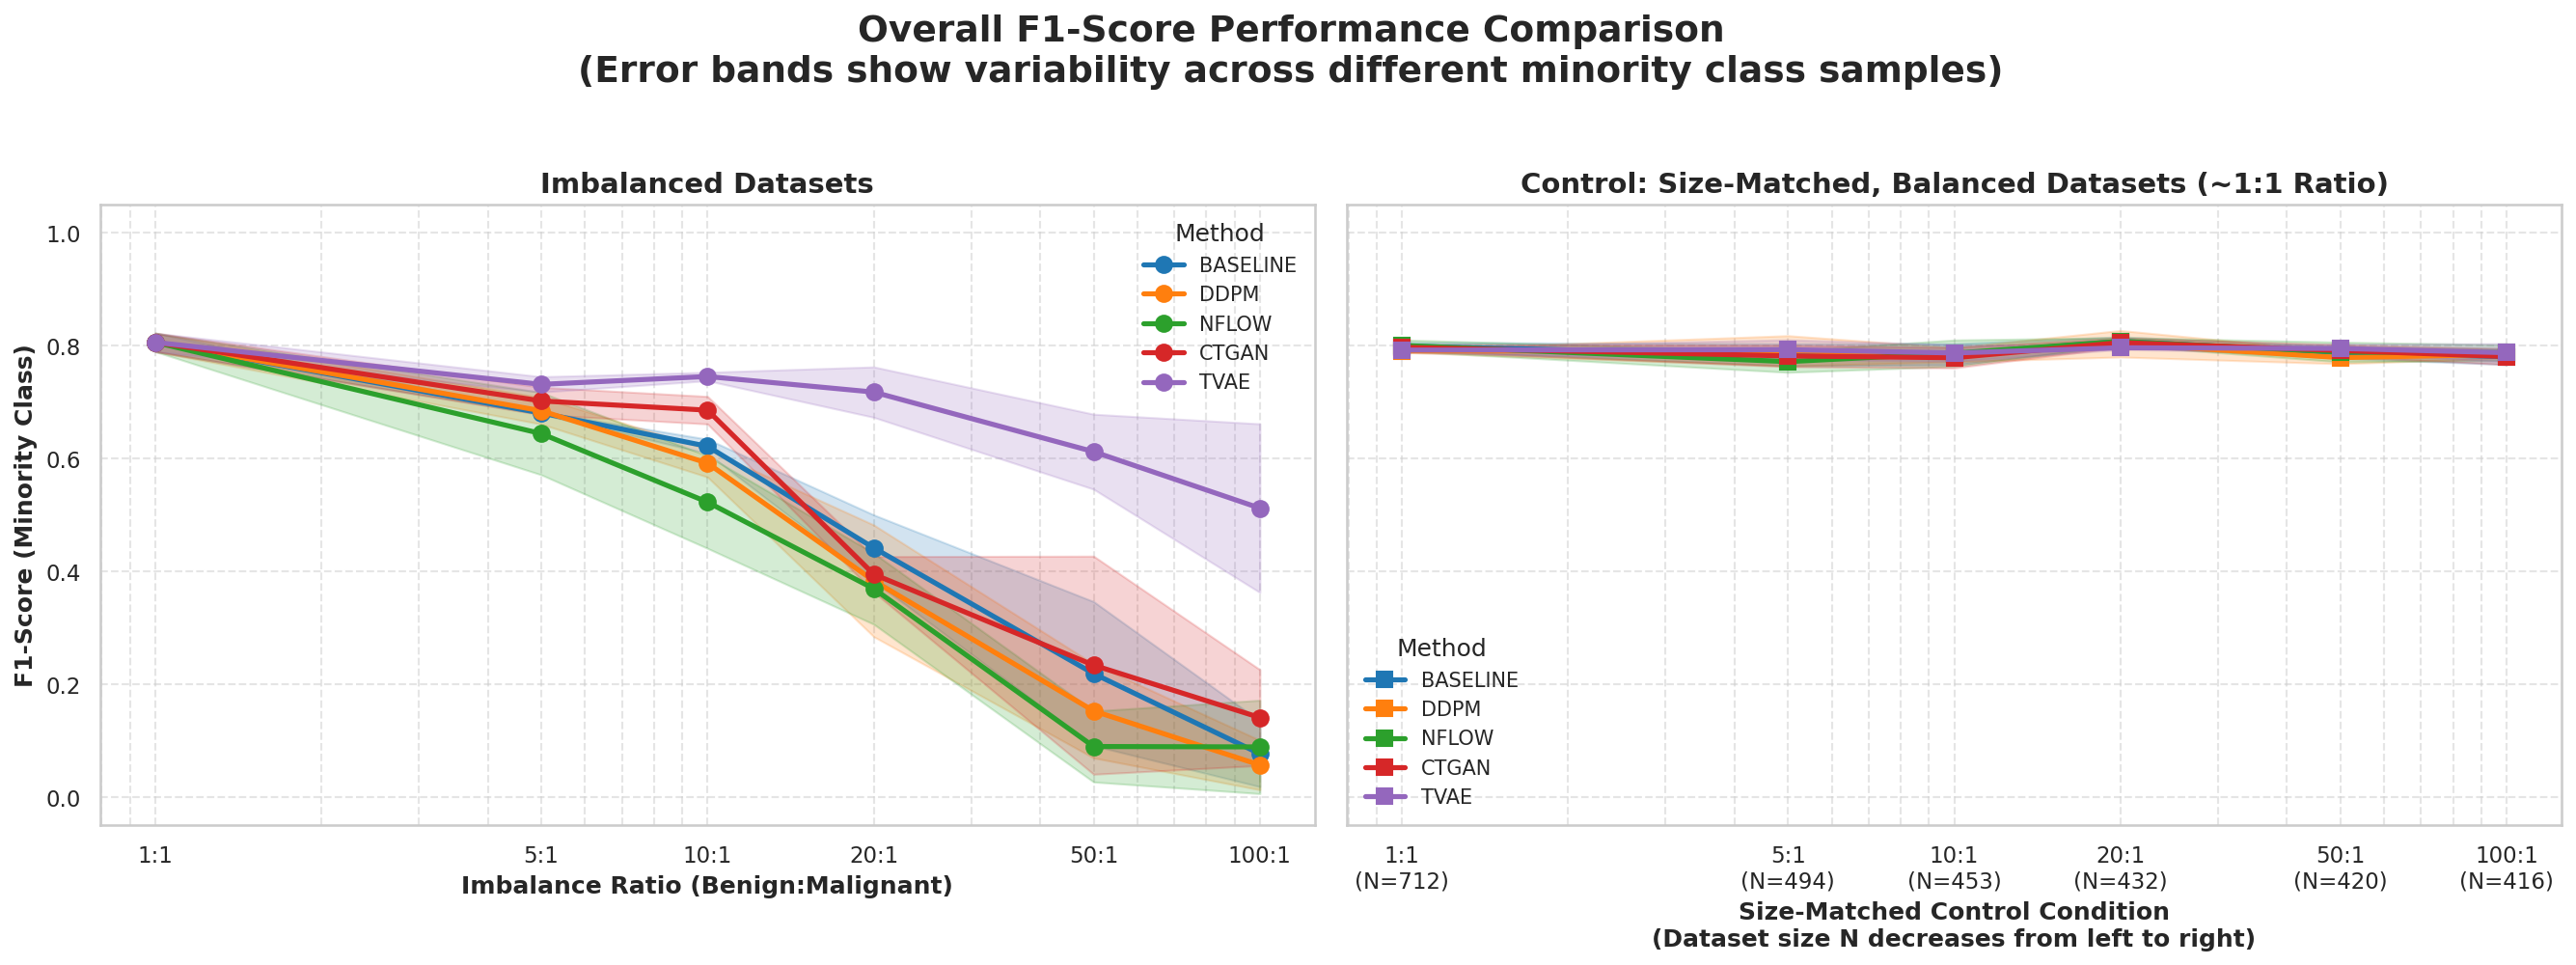

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Overall F1-Score Performance Comparison\n(Error bands show variability across different minority class samples)', 
             fontsize=18, fontweight='bold')

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']
control_data = summary_df[summary_df['dataset_type'] == 'control']

ax = axes[0]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='o', linewidth=2.5, markersize=8, label=model.upper(), 
            color=MODEL_COLORS[model])
    
    std_dev = model_data['f1_minority_std'].fillna(0)
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - std_dev,
                    model_data['f1_minority_mean'] + std_dev,
                    alpha=0.2, color=MODEL_COLORS[model])

ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Minority Class)', fontsize=12, fontweight='bold')
ax.set_title('Imbalanced Datasets', fontsize=14, fontweight='bold')
ax.legend(title='Method', fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_xscale('log')
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(-0.05, 1.05)


ax = axes[1]

control_sizes_df = detailed_df[detailed_df['dataset_type'] == 'control']
control_sizes = control_sizes_df.drop_duplicates(subset='ir_numeric').set_index('ir_numeric')['train_set_size'].to_dict()
x_labels_with_size = [f'{ir_str}\n(N={control_sizes.get(int(ir_str.split(":")[0]), "?")})' for ir_str in ['1:1', '5:1', '10:1', '20:1', '50:1', '100:1']]


for model in MODELS_TO_ANALYZE:
    model_data = control_data[control_data['model'] == model]
    if model_data.empty: 
        continue
        
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='s', linewidth=2.5, markersize=8, label=model.upper(), 
            color=MODEL_COLORS[model])
    
    std_dev = model_data['f1_minority_std'].fillna(0)
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - std_dev,
                    model_data['f1_minority_mean'] + std_dev,
                    alpha=0.2, color=MODEL_COLORS[model])

ax.set_xlabel('Size-Matched Control Condition\n(Dataset size N decreases from left to right)', fontsize=12, fontweight='bold')

ax.set_title('Control: Size-Matched, Balanced Datasets (~1:1 Ratio)', fontsize=14, fontweight='bold')

ax.legend(title='Method', fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_xscale('log')
ax.set_xticks([1, 5, 10, 20, 50, 100])

ax.set_xticklabels(x_labels_with_size)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'overall_f1_comparison_revised.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.2 Performance Degradation Analysis

Examining how all metrics degrade as imbalance increases.

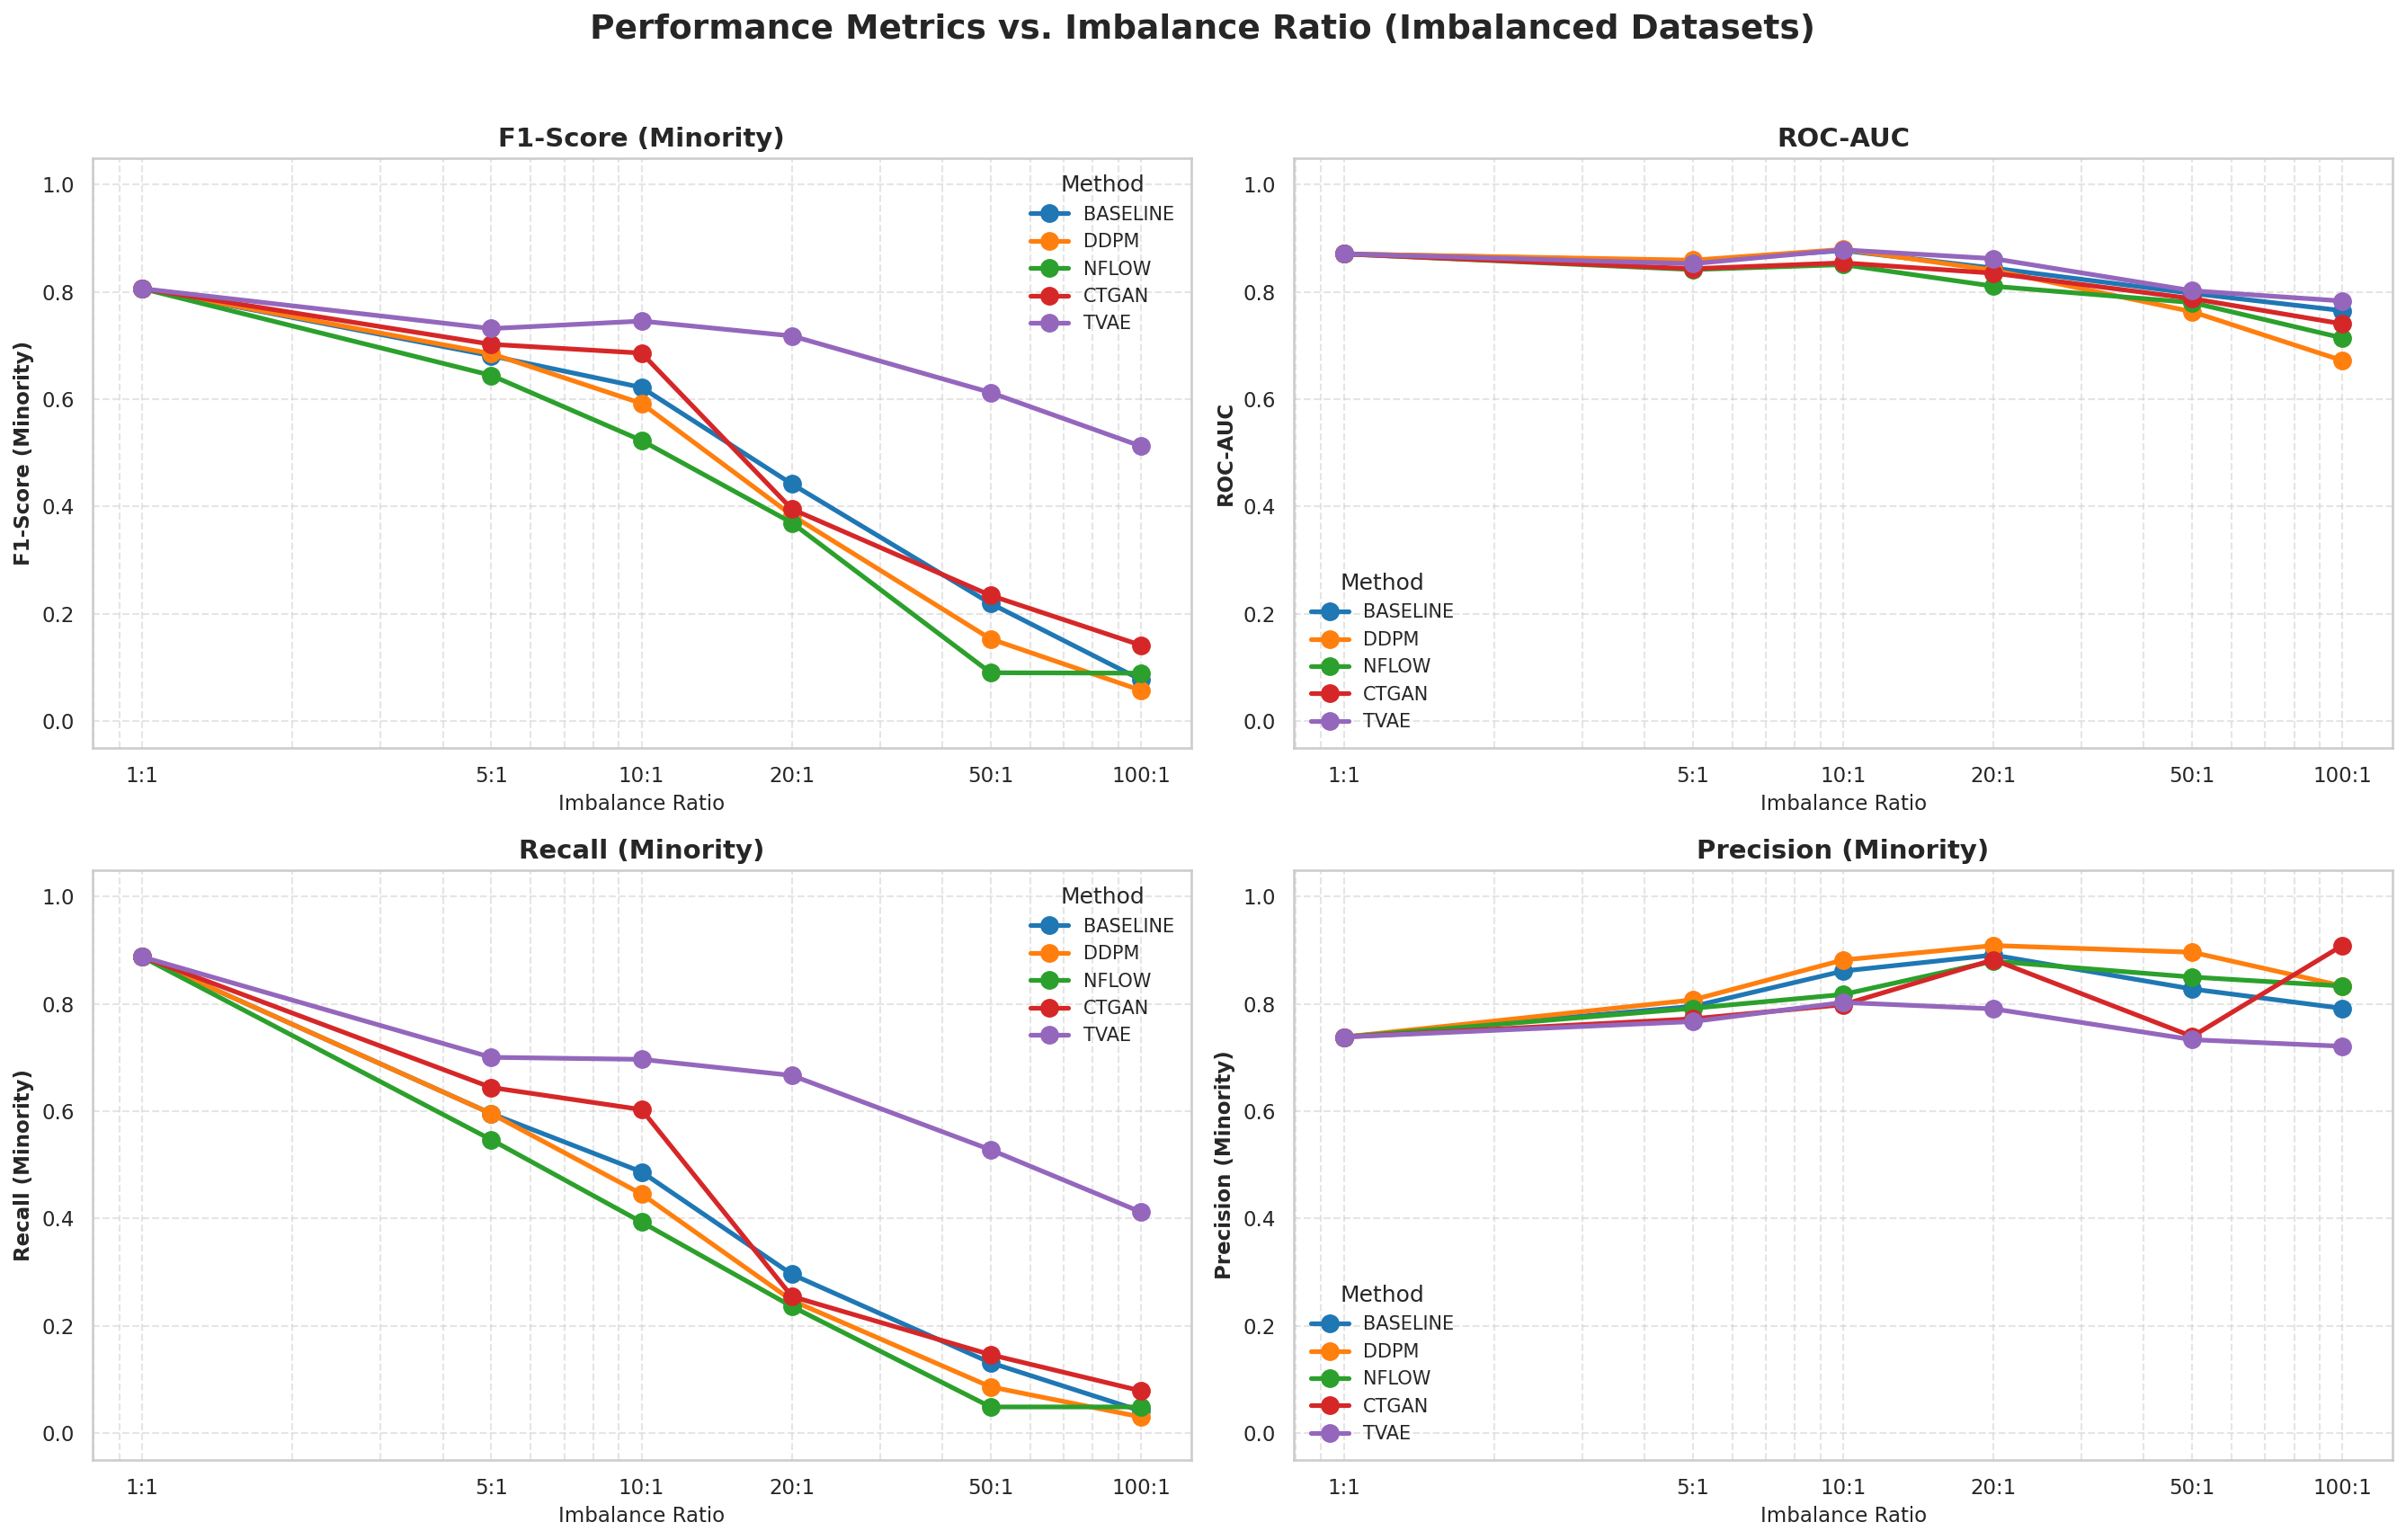

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Performance Metrics vs. Imbalance Ratio (Imbalanced Datasets)', 
             fontsize=18, fontweight='bold')

metrics = ['f1_minority_mean', 'roc_auc_mean', 'recall_minority_mean', 'precision_minority_mean']
titles = ['F1-Score (Minority)', 'ROC-AUC', 'Recall (Minority)', 'Precision (Minority)']

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for model in MODELS_TO_ANALYZE:
        model_data = imbalanced_data[imbalanced_data['model'] == model]
        if model_data.empty: 
            continue
        
        ax.plot(model_data['ir_numeric'], model_data[metric], 
                marker='o', linewidth=2.5, markersize=9, label=model.upper(), 
                color=MODEL_COLORS[model])
    
    ax.set_xscale('log')
    ax.set_xlabel('Imbalance Ratio', fontsize=11)
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(title='Method', fontsize=10)
    ax.grid(True, which="both", linestyle='--', alpha=0.5)
    ax.set_xticks([1, 5, 10, 20, 50, 100])
    ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(FIGURES_PATH / 'all_metrics_by_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.3 Relative Performance Improvement

Calculate the percentage improvement of each synthetic method over the baseline for each imbalance ratio.

In [85]:
imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced'].copy()

improvement_data = []
for ir in sorted(imbalanced_data['ir_numeric'].unique()):
    ir_data = imbalanced_data[imbalanced_data['ir_numeric'] == ir]
    baseline_f1 = ir_data[ir_data['model'] == 'baseline']['f1_minority_mean'].values[0]

    for model in SYNTHETIC_MODELS:
        model_f1_series = ir_data[ir_data['model'] == model]['f1_minority_mean']
        if model_f1_series.empty: 
            continue
        
        model_f1 = model_f1_series.values[0]
        improvement = ((model_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 1e-6 else 0
        
        improvement_data.append({
            'ir_numeric': ir, 
            'model': model, 
            'improvement_pct': improvement
        })

improvement_df = pd.DataFrame(improvement_data)

print("Improvement Statistics")
print(improvement_df.groupby('model')['improvement_pct'].describe())

Improvement Statistics
       count        mean         std        min        25%        50%  \
model                                                                   
ctgan    6.0   15.497684   33.974972 -10.577824   0.784255   4.987275   
ddpm     6.0  -12.226115   13.228011 -30.141365 -22.651630  -8.994843   
nflow    6.0  -13.455717   25.235820 -58.915791 -16.249362 -10.632967   
tvae     6.0  138.970633  218.814705   0.000000  10.556248  41.188299   

              75%         max  
model                          
ctgan    9.429918   83.295333  
ddpm    -1.197799    0.577038  
nflow   -1.340837   15.812374  
tvae   150.209799  564.551337  


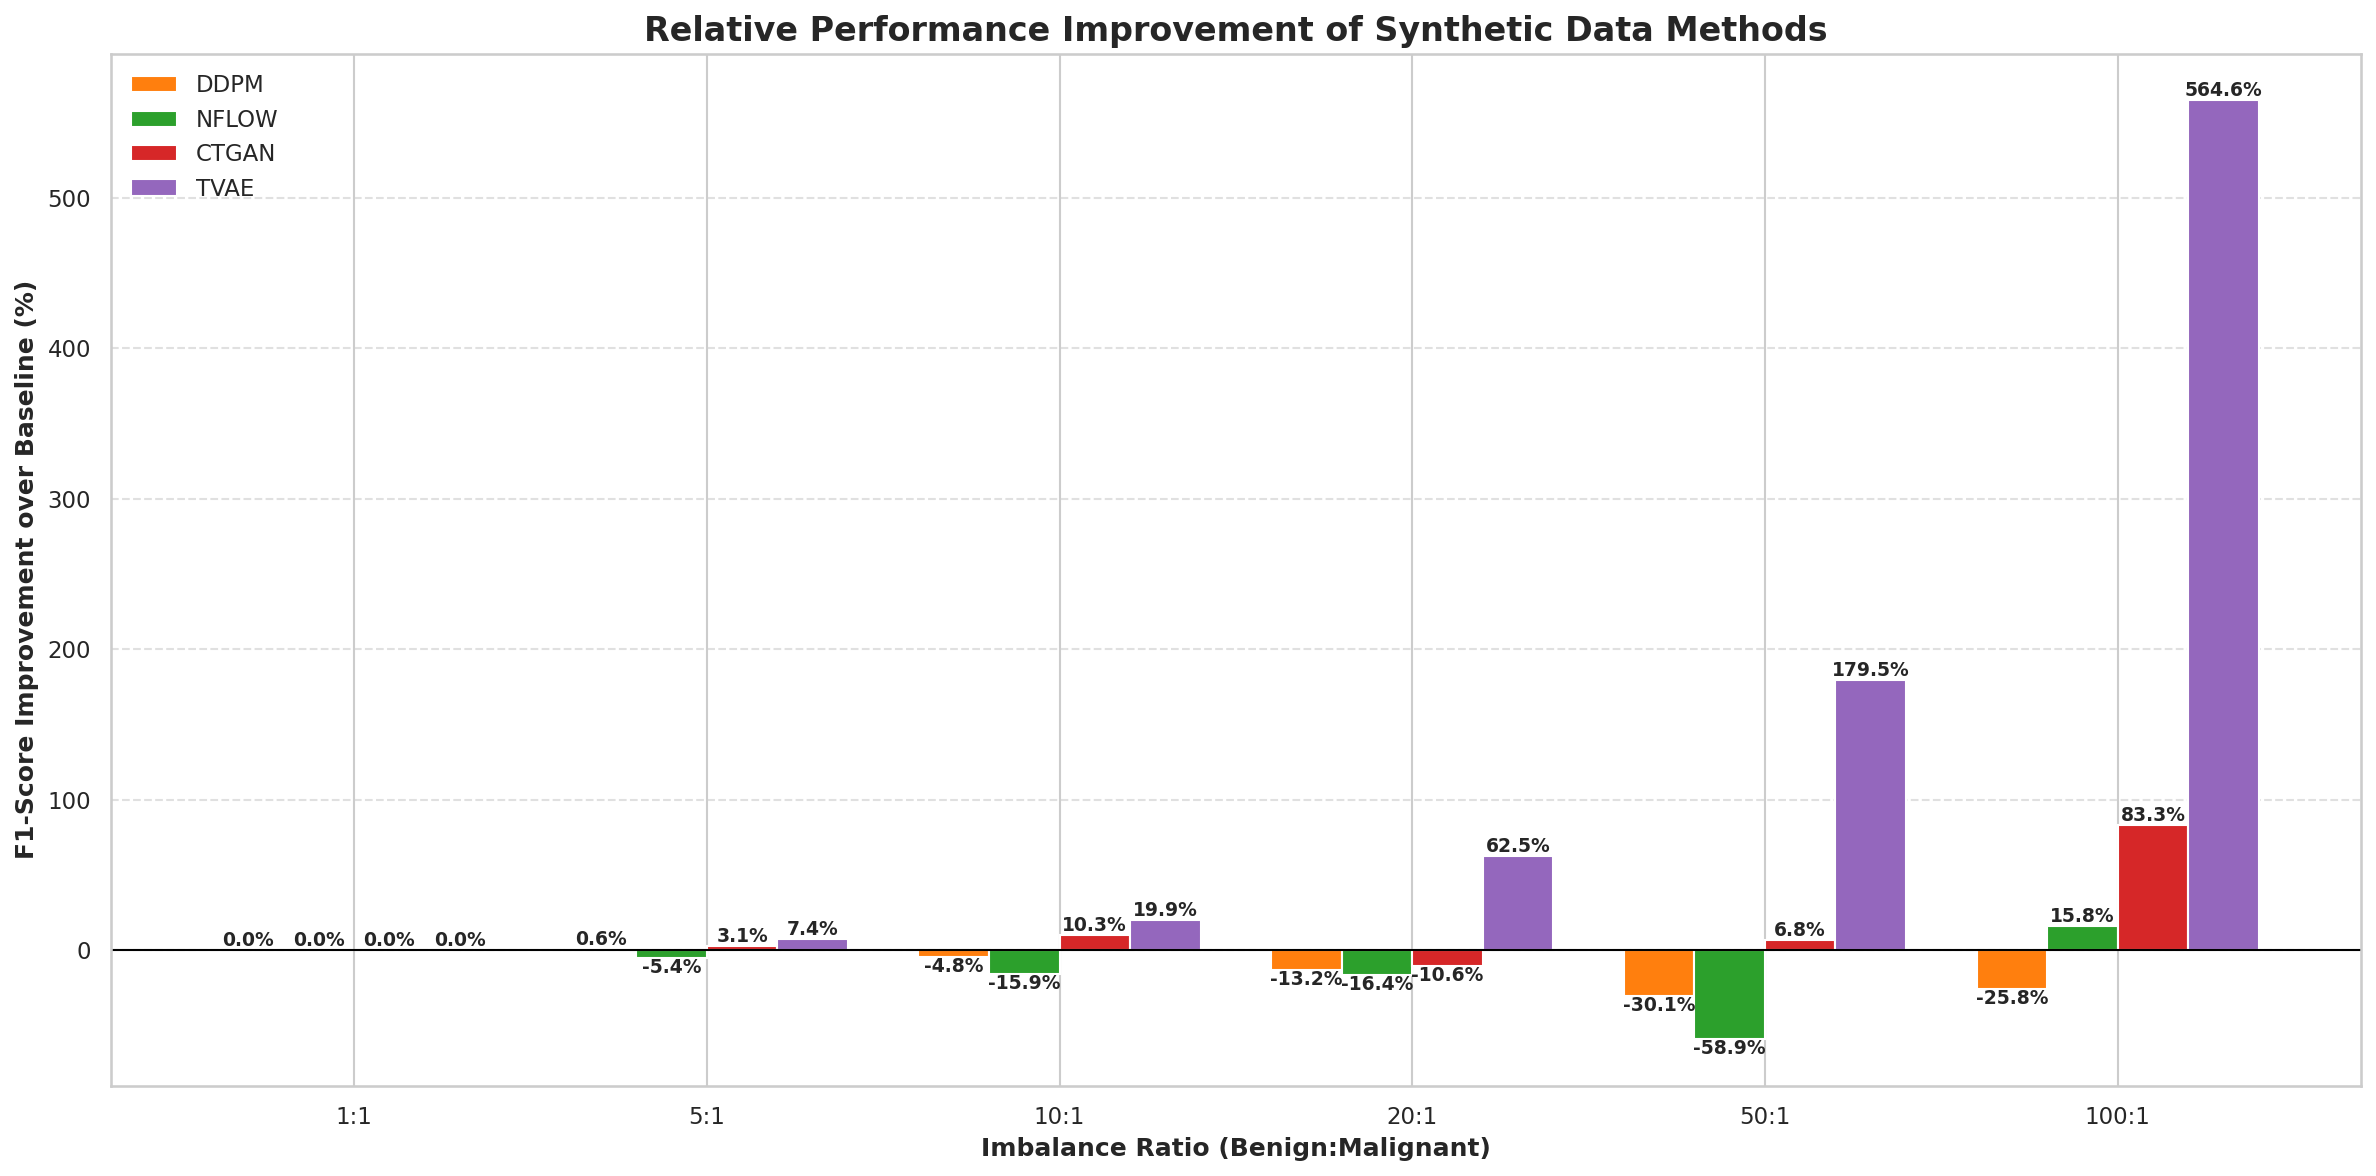

In [86]:
fig, ax = plt.subplots(figsize=(16, 8))
n_generators = len(SYNTHETIC_MODELS)
x = np.arange(len(improvement_df['ir_numeric'].unique()))
width = 0.8 / n_generators
x_labels = [f'{ir}:1' for ir in sorted(improvement_df['ir_numeric'].unique())]

for i, model in enumerate(SYNTHETIC_MODELS):
    model_data = improvement_df[improvement_df['model'] == model]
    offset = width * (i - (n_generators - 1) / 2)
    bars = ax.bar(x + offset, model_data['improvement_pct'], width, 
                   label=model.upper(), color=MODEL_COLORS[model])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%',
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Relative Performance Improvement of Synthetic Data Methods', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'improvement_over_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.4 Precision-Recall Trade-off Analysis


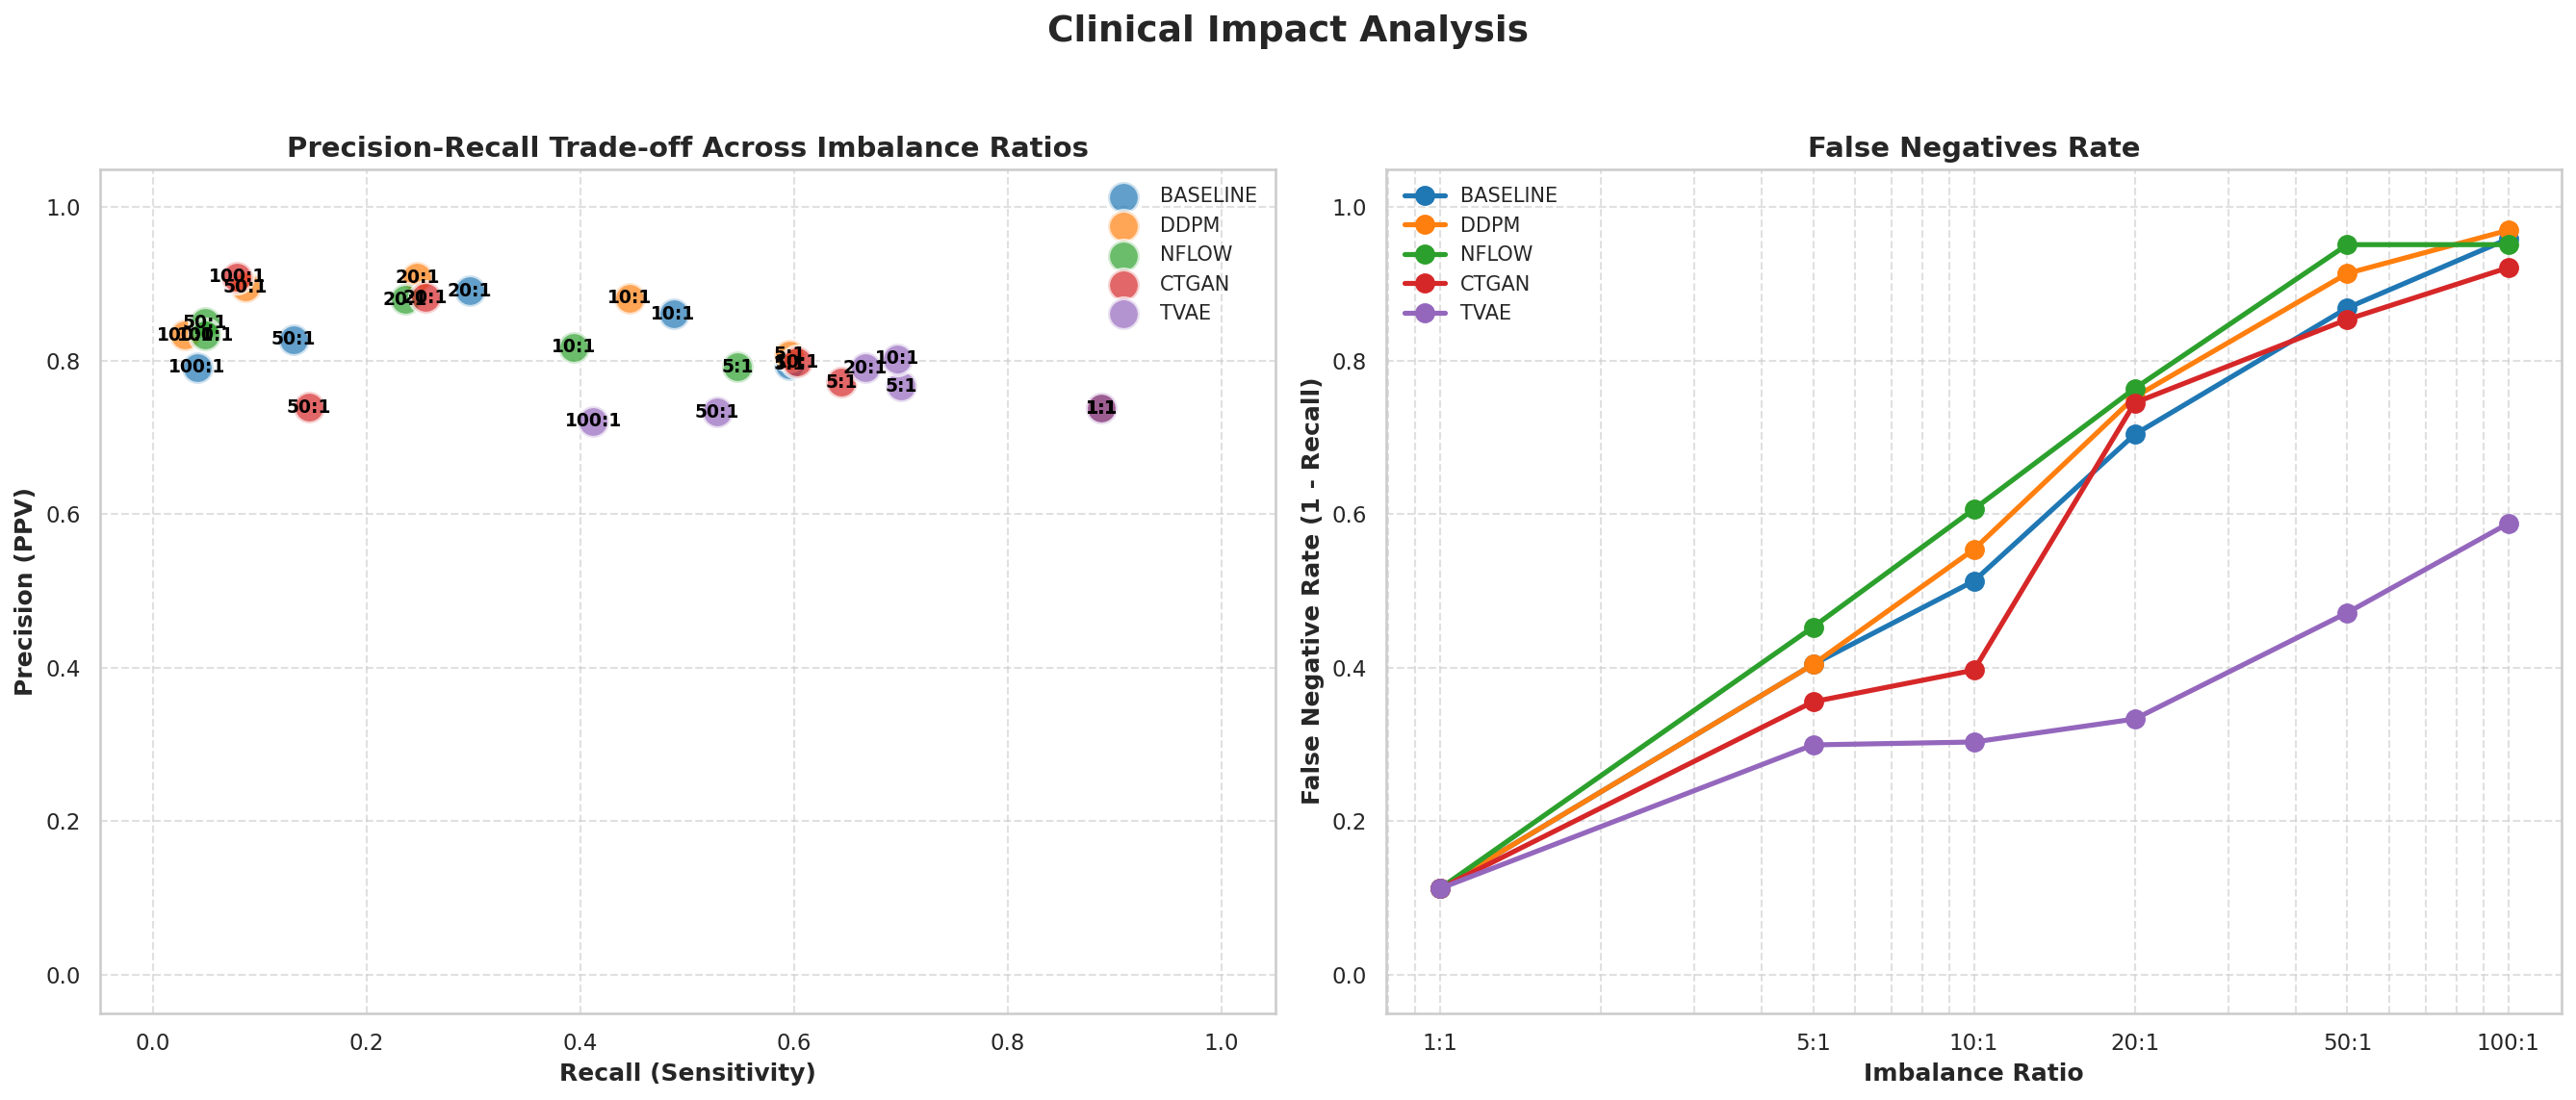

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Clinical Impact Analysis', fontsize=18, fontweight='bold')
imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']

# Plot 1: Precision vs Recall scatter
ax = axes[0]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    ax.scatter(model_data['recall_minority_mean'], model_data['precision_minority_mean'],
               s=250, alpha=0.7, label=model.upper(), color=MODEL_COLORS[model], 
               edgecolors='w', linewidth=2)
    
    for _, row in model_data.iterrows():
        ax.annotate(f"{row['ir_numeric']}:1", 
                    (row['recall_minority_mean'], row['precision_minority_mean']),
                    fontsize=9, ha='center', va='center', color='black', weight='bold')

ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Across Imbalance Ratios', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# Plot 2: False Negative Rate
ax = axes[1]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    fnr = 1 - model_data['recall_minority_mean']
    ax.plot(model_data['ir_numeric'], fnr, marker='o', linewidth=2.5, markersize=9, 
            label=f'{model.upper()}', color=MODEL_COLORS[model])

ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('False Negative Rate (1 - Recall)', fontsize=12, fontweight='bold')
ax.set_title('False Negatives Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.6)
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'precision_recall_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Part 2: Synthetic Data Quality Analysis

This section evaluates the intrinsic quality of synthetic data using pyMDMA metrics, independent of downstream performance. We assess statistical fidelity, robustness, and privacy preservation.

## 2.1 Quality Metrics Calculation Functions

In [88]:
def calculate_pyMDMA_metrics(real_df: pd.DataFrame, synthetic_df: pd.DataFrame) -> dict:
    real_features = real_df.drop(columns=[TARGET_FEATURE]).to_numpy()
    synthetic_features = synthetic_df.drop(columns=[TARGET_FEATURE]).to_numpy()

    metrics = {
        "precision": ImprovedPrecision(),  
        "recall": ImprovedRecall(),  
        "density": Density(),
        "coverage": Coverage(),
        "authenticity": Authenticity(),
    }
    
    results = {
        name: metric.compute(real_features, synthetic_features).dataset_level.value
        for name, metric in metrics.items()
    }
    return results

## 2.2 Compute Quality Metrics for All Experiments

In [89]:
all_results_runs = []

total_evals = len(IMBALANCE_RATIOS) * len(GENERATORS) * N_REPETITIONS
print(f"Starting evaluation of {total_evals} experimental conditions...\n")

pbar = tqdm(total=total_evals, desc="Processing Experiments")

for ir in IMBALANCE_RATIOS:
    for generator in GENERATORS:
        for rep_id in range(1, N_REPETITIONS + 1):
            real_path = PROCESSED_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}.csv"
            synth_path = SYNTHETIC_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}_balanced_by_{generator}.csv"

            if not synth_path.exists():
                warnings.warn(f"File not found, skipping: {synth_path.name}")
                pbar.update(1)
                continue

            real_df = pd.read_csv(real_path)
            synthetic_df = pd.read_csv(synth_path)

            pyMDMA_metrics = calculate_pyMDMA_metrics(real_df, synthetic_df)

            result_entry = {
                "ir": ir,
                "generator": generator.upper(),
                "repetition_id": rep_id,
                **pyMDMA_metrics
            }
            all_results_runs.append(result_entry)
            pbar.update(1)

pbar.close()
quality_metrics_df = pd.DataFrame(all_results_runs)

utility_df = detailed_df[
    (detailed_df['dataset_type'] == 'imbalanced') &
    (detailed_df['model'].isin([g.lower() for g in GENERATORS]))
].copy()

utility_df['generator'] = utility_df['model'].str.upper()

utility_df = utility_df[['ir_numeric', 'generator', 'repetition_id', 'roc_auc']].copy()
utility_df.rename(columns={'ir_numeric': 'ir'}, inplace=True)

raw_results_df = quality_metrics_df.merge(
    utility_df,
    on=['ir', 'generator', 'repetition_id'],
    how='left'
)

print(f"\nQuality metrics computed for {len(quality_metrics_df)} conditions")
print(f"Successfully merged with utility metrics from CSV: {len(raw_results_df)} total entries")
print(f"Missing utility values: {raw_results_df['roc_auc'].isna().sum()}")

Starting evaluation of 72 experimental conditions...



Processing Experiments:   0%|          | 0/72 [00:00<?, ?it/s]


Quality metrics computed for 60 conditions
Successfully merged with utility metrics from CSV: 60 total entries
Missing utility values: 0


In [90]:
metric_columns = [col for col in raw_results_df.columns 
                 if col not in ['ir', 'generator', 'repetition_id']]

agg_dict = {col: ['mean', 'std'] for col in metric_columns}

results_df = raw_results_df.groupby(['ir', 'generator']).agg(agg_dict).reset_index()

results_df.columns = ['_'.join(col).strip() if col[1] else col[0] 
                      for col in results_df.columns.values]

## 2.3 Quality Metrics Trends vs Imbalance Ratio

Lines show mean performance across 3 repetitions, with shaded bands showing ±1 standard deviation.

In [91]:
def plot_metric_trend(data, metric, ax, title, y_label, y_lim=(0, None)):
    metric_mean = f"{metric}_mean"
    metric_std = f"{metric}_std"
    
    for gen, style in GENERATOR_STYLES.items():
        gen_data = data[data['generator'] == gen]
        if gen_data.empty:
            continue
            
        ax.plot(
            gen_data['ir'], 
            gen_data[metric_mean],
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            label=gen,
            markersize=8, 
            linewidth=2.5
        )
        
        std_dev = gen_data[metric_std].fillna(0)
        ax.fill_between(
            gen_data['ir'],
            gen_data[metric_mean] - std_dev,
            gen_data[metric_mean] + std_dev,
            color=style['color'],
            alpha=0.15
        )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Imbalance Ratio (Log Scale)', fontsize=12)
    ax.set_xscale('log')
    ax.set_xticks(IMBALANCE_RATIOS)
    ax.set_xticklabels([f"{ir}:1" for ir in IMBALANCE_RATIOS])
    if y_lim:
        ax.set_ylim(y_lim)
    ax.legend(title='Generator', loc='best')
    ax.grid(True, which="both", ls="--", c='0.85')

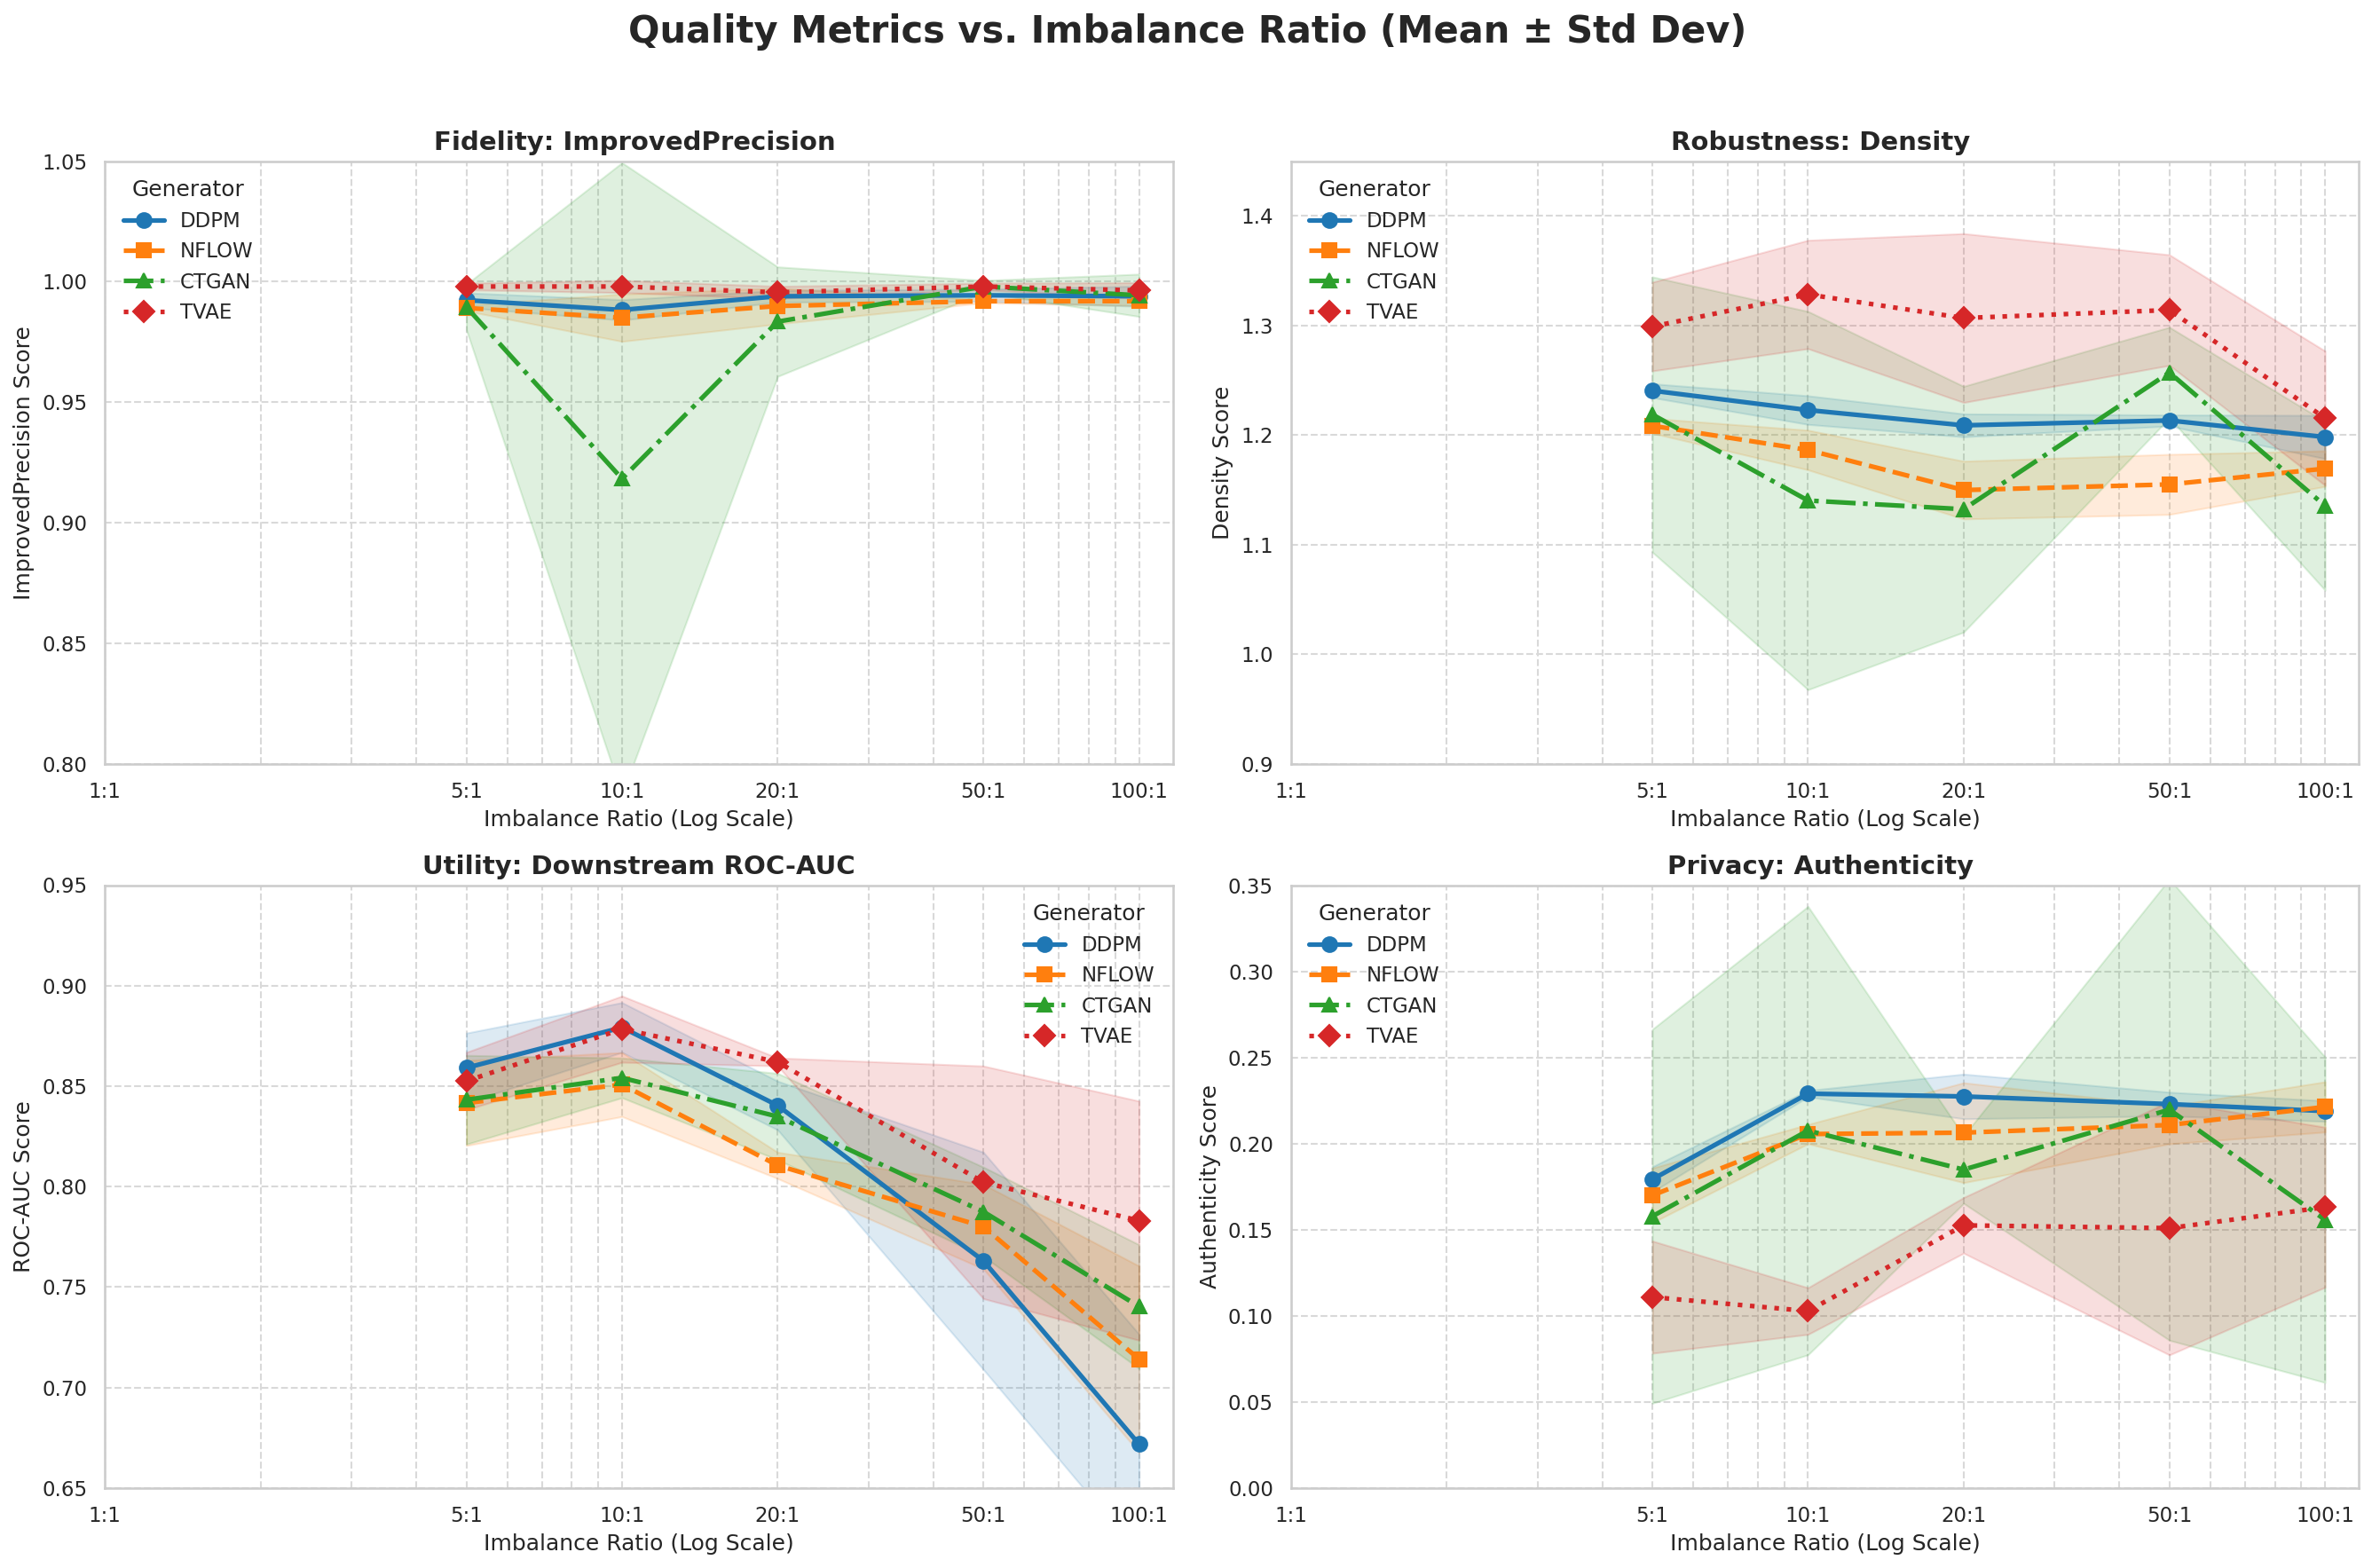

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Quality Metrics vs. Imbalance Ratio (Mean ± Std Dev)', 
             fontsize=20, fontweight='bold')

plot_metric_trend(results_df, 'precision', axes[0, 0], 'Fidelity: ImprovedPrecision ', 'ImprovedPrecision Score', y_lim=(0.8, 1.05))
plot_metric_trend(results_df, 'density', axes[0, 1], 'Robustness: Density ', 'Density Score', y_lim=(0.9, 1.45))
plot_metric_trend(results_df, 'roc_auc', axes[1, 0], 'Utility: Downstream ROC-AUC', 'ROC-AUC Score', y_lim=(0.65, 0.95))
plot_metric_trend(results_df, 'authenticity', axes[1, 1], 'Privacy: Authenticity ', 'Authenticity Score', y_lim=(0, 0.35))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'quality_trends_with_error.png', dpi=300)
plt.show()

## 2.4 Per-Generator Analysis: Input IR vs Quality

Faceted view showing how each generator's quality metrics respond to different input imbalance ratios.

In [93]:
output_ratio_results = []

for ir in IMBALANCE_RATIOS:
    for generator in GENERATORS:
        for rep_id in range(1, N_REPETITIONS + 1):
            synth_path = SYNTHETIC_PATH / f"train_imbalanced_ir_{ir}_rep{rep_id}_balanced_by_{generator}.csv"
            
            if not synth_path.exists():
                continue
            
            synthetic_df = pd.read_csv(synth_path)
            value_counts = synthetic_df[TARGET_FEATURE].value_counts()
            
            if len(value_counts) >= 2 and value_counts.min() > 0:
                output_ir = value_counts.max() / value_counts.min()
                output_ratio_results.append({
                    'input_ir': ir,
                    'generator': generator.upper(),
                    'repetition_id': rep_id,
                    'output_ir': round(output_ir, 2),
                    'n_majority': int(value_counts.max()),
                    'n_minority': int(value_counts.min())
                })

output_ratio_df = pd.DataFrame(output_ratio_results)

results_with_output_ir = raw_results_df.merge(
    output_ratio_df, 
    left_on=['ir', 'generator', 'repetition_id'],
    right_on=['input_ir', 'generator', 'repetition_id'],
    how='left'
)

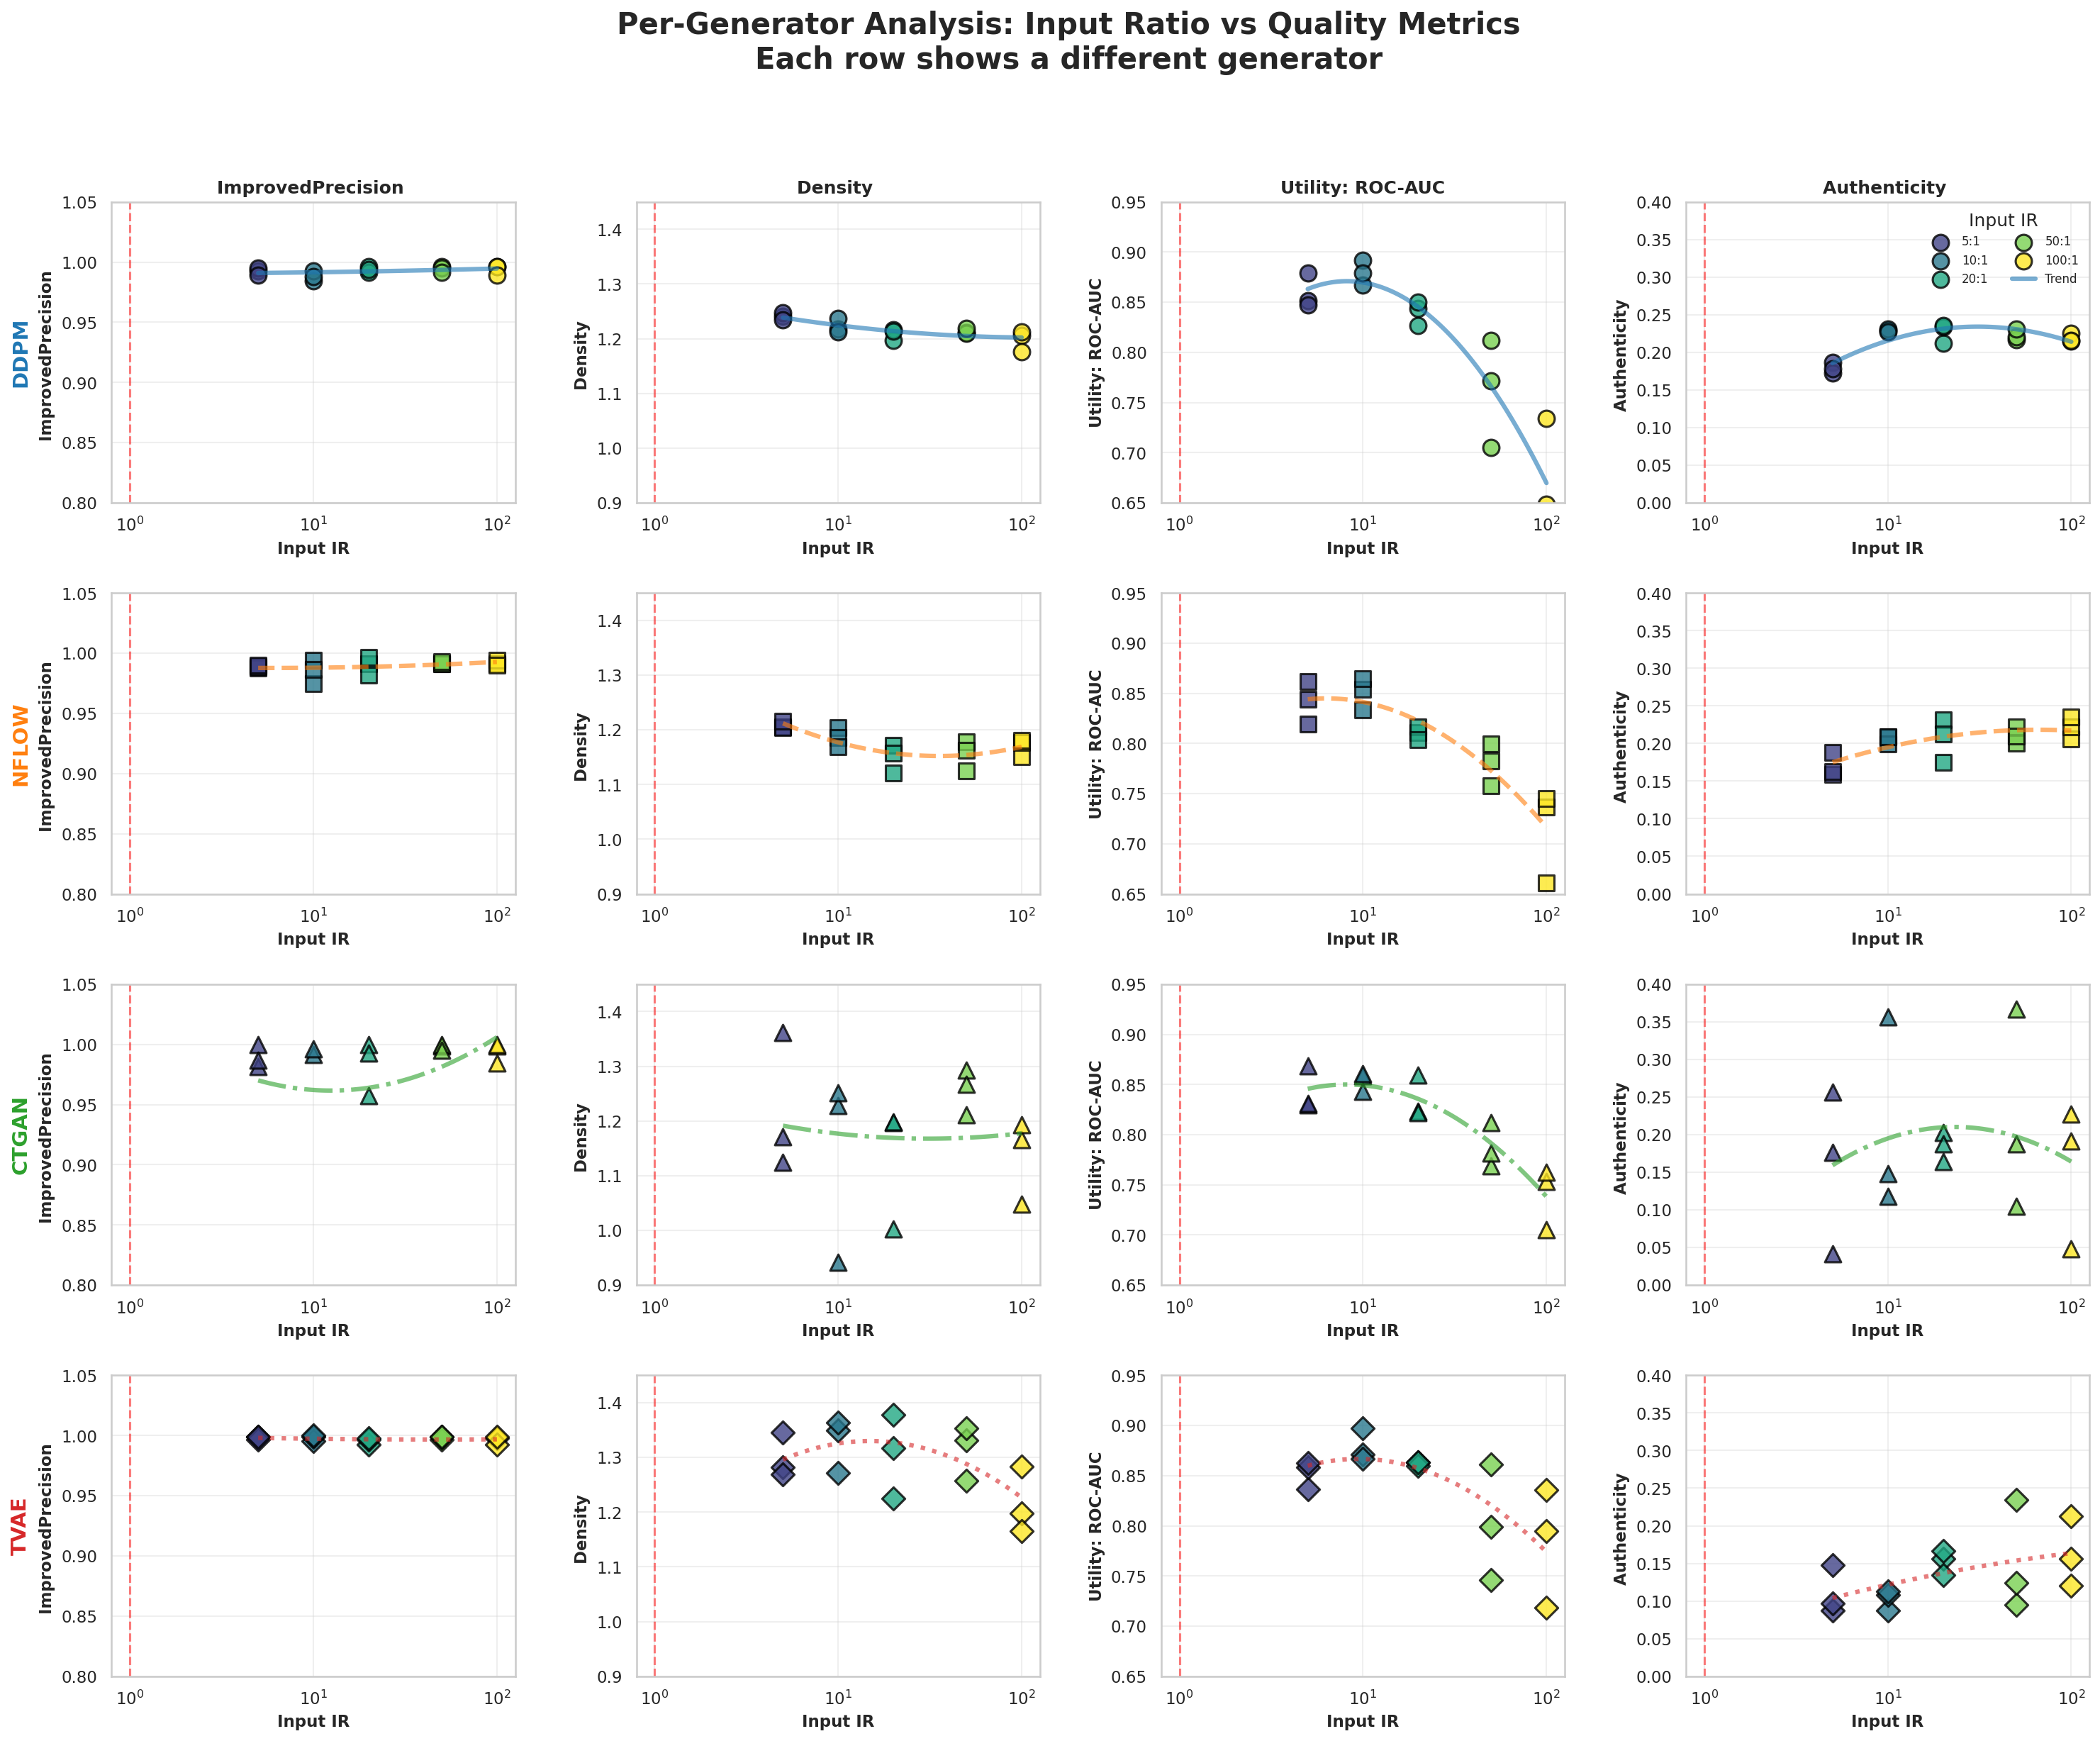

In [94]:
metrics = ['precision', 'density', 'roc_auc', 'authenticity']
titles = ['ImprovedPrecision ', 'Density ', 'Utility: ROC-AUC', 'Authenticity ']
y_lims = [(0.8, 1.05), (0.9, 1.45), (0.65, 0.95), (0, 0.4)]
input_ir_colors = plt.cm.viridis(np.linspace(0, 1, len(IMBALANCE_RATIOS)))
input_ir_color_map = dict(zip(IMBALANCE_RATIOS, input_ir_colors))

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

fig.suptitle('Per-Generator Analysis: Input Ratio vs Quality Metrics\n' + 
             'Each row shows a different generator', 
             fontsize=20, fontweight='bold')

for gen_idx, (gen, style) in enumerate(GENERATOR_STYLES.items()):
    gen_data = results_with_output_ir[results_with_output_ir['generator'] == gen]
    
    for metric_idx, (metric, metric_title, y_lim) in enumerate(zip(metrics, titles, y_lims)):
        ax = fig.add_subplot(gs[gen_idx, metric_idx])
        
        if not gen_data.empty:
            for ir in IMBALANCE_RATIOS:
                ir_data = gen_data[gen_data['input_ir'] == ir]
                if not ir_data.empty:
                    ax.scatter(
                        ir_data['input_ir'],
                        ir_data[metric],
                        color=input_ir_color_map[ir],
                        marker=style['marker'],
                        s=120,
                        alpha=0.8,
                        edgecolors='black',
                        linewidths=1.5,
                        label=f'{ir}:1'
                    )
            
            valid_data = gen_data[gen_data['input_ir'].notna() & gen_data[metric].notna()]
            if len(valid_data) > 3:
                log_input_ir = np.log10(valid_data['input_ir'].values)
                metric_vals = valid_data[metric].values
                
                mask = np.isfinite(log_input_ir) & np.isfinite(metric_vals)
                if mask.sum() > 3:
                    z = np.polyfit(log_input_ir[mask], metric_vals[mask], 2)
                    p = np.poly1d(z)
                    
                    x_smooth = np.linspace(log_input_ir[mask].min(), log_input_ir[mask].max(), 100)
                    y_smooth = p(x_smooth)
                    
                    ax.plot(10**x_smooth, y_smooth, color=style['color'], 
                           linewidth=3, linestyle=style['linestyle'], alpha=0.6, 
                           label='Trend')
        
        ax.set_xscale('log')
        ax.set_xlabel('Input IR', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric_title, fontsize=11, fontweight='bold')
        
        if y_lim:
            ax.set_ylim(y_lim)
        
        ax.grid(True, alpha=0.3)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
        
        if gen_idx == 0:
            ax.set_title(metric_title, fontsize=12, fontweight='bold')
        
        if metric_idx == 0:
            ax.text(-0.25, 0.5, gen, transform=ax.transAxes,
                   fontsize=14, fontweight='bold', rotation=90,
                   verticalalignment='center', color=style['color'])
        
        if gen_idx == 0 and metric_idx == 3:
            ax.legend(title='Input IR', fontsize=8, loc='upper right', ncol=2)

plt.savefig(FIGURES_PATH / 'per_generator_faceted_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.5 Distribution Analysis: Variability Across Repetitions

In [95]:
def plot_metric_boxplots_all_generators(data, metric, ax, title, y_label, y_lim=(0, None)):
    plot_data = []
    positions = []
    colors = []
    ir_positions_per_gen = {gen: [] for gen in GENERATOR_STYLES.keys()}
    
    generators_list = list(GENERATOR_STYLES.keys())
    available_irs = sorted(data['ir'].unique())
    
    for i, gen in enumerate(generators_list):
        for j, ir in enumerate(available_irs):
            gen_data = data[(data['ir'] == ir) & (data['generator'] == gen)]
            if not gen_data.empty:
                values = gen_data[metric].values
                plot_data.append(values)
                pos = i * (len(available_irs) + 1.5) + j
                positions.append(pos)
                colors.append(GENERATOR_STYLES[gen]['color'])
                ir_positions_per_gen[gen].append((pos, ir))
    
    bp = ax.boxplot(plot_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=True,
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.2),
                    whiskerprops=dict(linewidth=1.2),
                    capprops=dict(linewidth=1.2),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, 
                                   markeredgecolor='darkred', linewidth=1))
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    
    tick_positions = [i * (len(available_irs) + 1.5) + (len(available_irs) - 1) / 2 
                     for i in range(len(generators_list))]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(generators_list, fontsize=13, fontweight='bold')
    
    for i in range(1, len(generators_list)):
        x_pos = i * (len(available_irs) + 1.5) - 0.75
        ax.axvline(x=x_pos, color='gray', linestyle='--', linewidth=1.5, alpha=0.4)
    
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    
    if y_lim:
        y_min, y_max = y_lim
        if y_max is None:
            y_max = ax.get_ylim()[1]
        if y_min is None:
            y_min = ax.get_ylim()[0]
    else:
        y_min, y_max = ax.get_ylim()
    
    y_range = y_max - y_min
    y_min_adjusted = y_min - y_range * 0.12
    ax.set_ylim(y_min_adjusted, y_max)
    
    y_pos = y_min - y_range * 0.06
    
    for gen in generators_list:
        if ir_positions_per_gen[gen]:
            for pos, ir in ir_positions_per_gen[gen]:
                ax.text(pos, y_pos, f'{ir}:1', 
                       ha='center', va='top', fontsize=9, 
                       rotation=0, color='dimgray')
    
    for i in range(0, len(generators_list), 2):
        x_start = i * (len(available_irs) + 1.5) - 0.75
        x_end = (i + 1) * (len(available_irs) + 1.5) - 0.75
        ax.axvspan(x_start, x_end, alpha=0.05, color='gray', zorder=0)
    
    ax.grid(True, axis='y', ls='--', c='0.85', alpha=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    ax.set_xlim(-0.5, len(generators_list) * (len(available_irs) + 1.5) - 1)

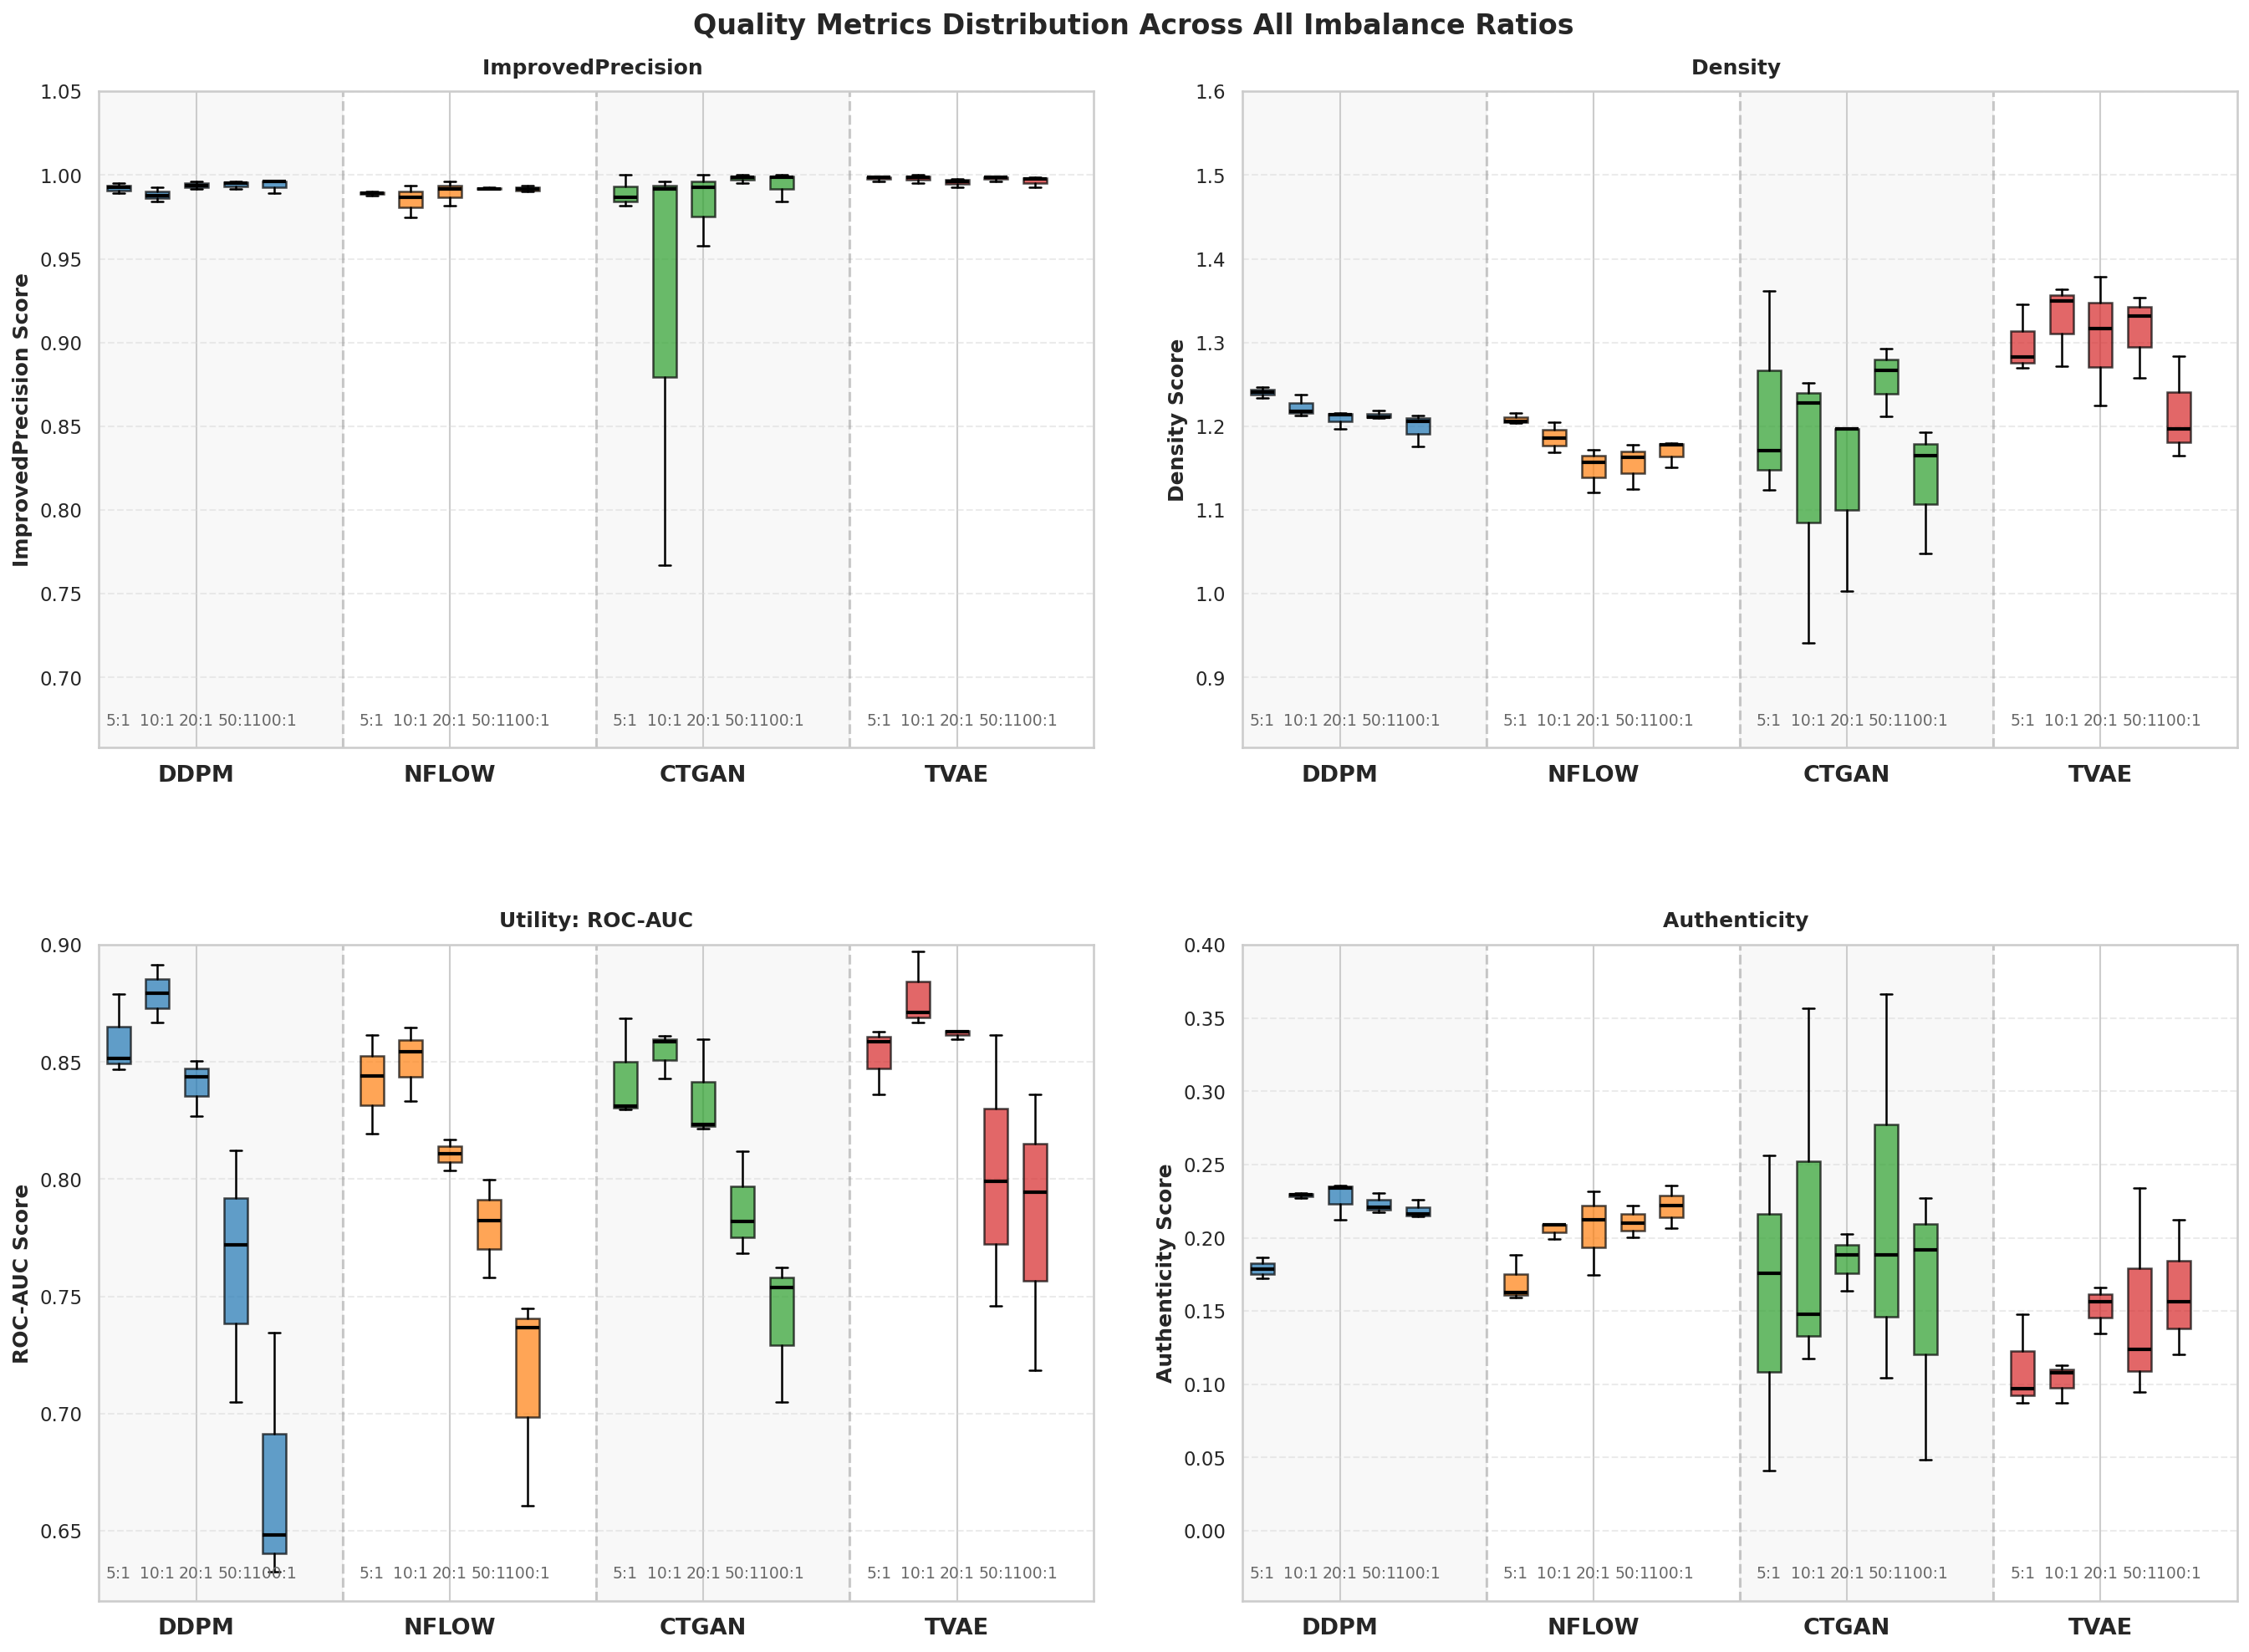

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(22, 14))
fig.suptitle('Quality Metrics Distribution Across All Imbalance Ratios',
             fontsize=16, fontweight='bold', y=0.985)

plot_metric_boxplots_all_generators(raw_results_df, 'precision', axes[0, 0], 
                                   'ImprovedPrecision ', 
                                   'ImprovedPrecision Score', y_lim=(0.7, 1.05))

plot_metric_boxplots_all_generators(raw_results_df, 'density', axes[0, 1], 
                                   'Density ', 
                                   'Density Score', y_lim=(0.9, 1.6))

plot_metric_boxplots_all_generators(raw_results_df, 'roc_auc', axes[1, 0], 
                                   'Utility: ROC-AUC', 
                                   'ROC-AUC Score', y_lim=(0.65, 0.90))

plot_metric_boxplots_all_generators(raw_results_df, 'authenticity', axes[1, 1], 
                                   'Authenticity ', 
                                   'Authenticity Score', y_lim=(0, 0.4))

plt.subplots_adjust(bottom=0.08, top=0.94, hspace=0.30, wspace=0.15)
plt.savefig(FIGURES_PATH / 'quality_distribution_all_generators.png', 
           dpi=300, bbox_inches='tight')
plt.show()

## 2.6 Overall Distribution: Combined View

Understanding overall behavior across all generators for each imbalance ratio.

In [97]:
def plot_metric_boxplots_combined(data, metric, ax, title, y_label, y_lim=(0, None)):
    plot_data = []
    positions = []
    ir_labels = []
    
    for i, ir in enumerate(IMBALANCE_RATIOS):
        ir_data = data[data['ir'] == ir]
        if not ir_data.empty:
            values = ir_data[metric].values
            plot_data.append(values)
            positions.append(i)
            ir_labels.append(f"{ir}:1")
    
    bp = ax.boxplot(plot_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='darkblue', linewidth=2.5),
                    boxprops=dict(linewidth=1.5, facecolor='lightblue'),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=8, 
                                   markeredgecolor='darkred', linewidth=1.5))
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(plot_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(ir_labels)
    ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if y_lim:
        ax.set_ylim(y_lim)
    
    for i, (pos, data_values) in enumerate(zip(positions, plot_data)):
        n_samples = len(data_values)
        ax.text(pos, ax.get_ylim()[1] * 0.98, f'n={n_samples}', 
               ha='center', va='top', fontsize=9, color='darkgray')
    
    ax.grid(True, axis='y', ls='--', c='0.85', alpha=0.7)

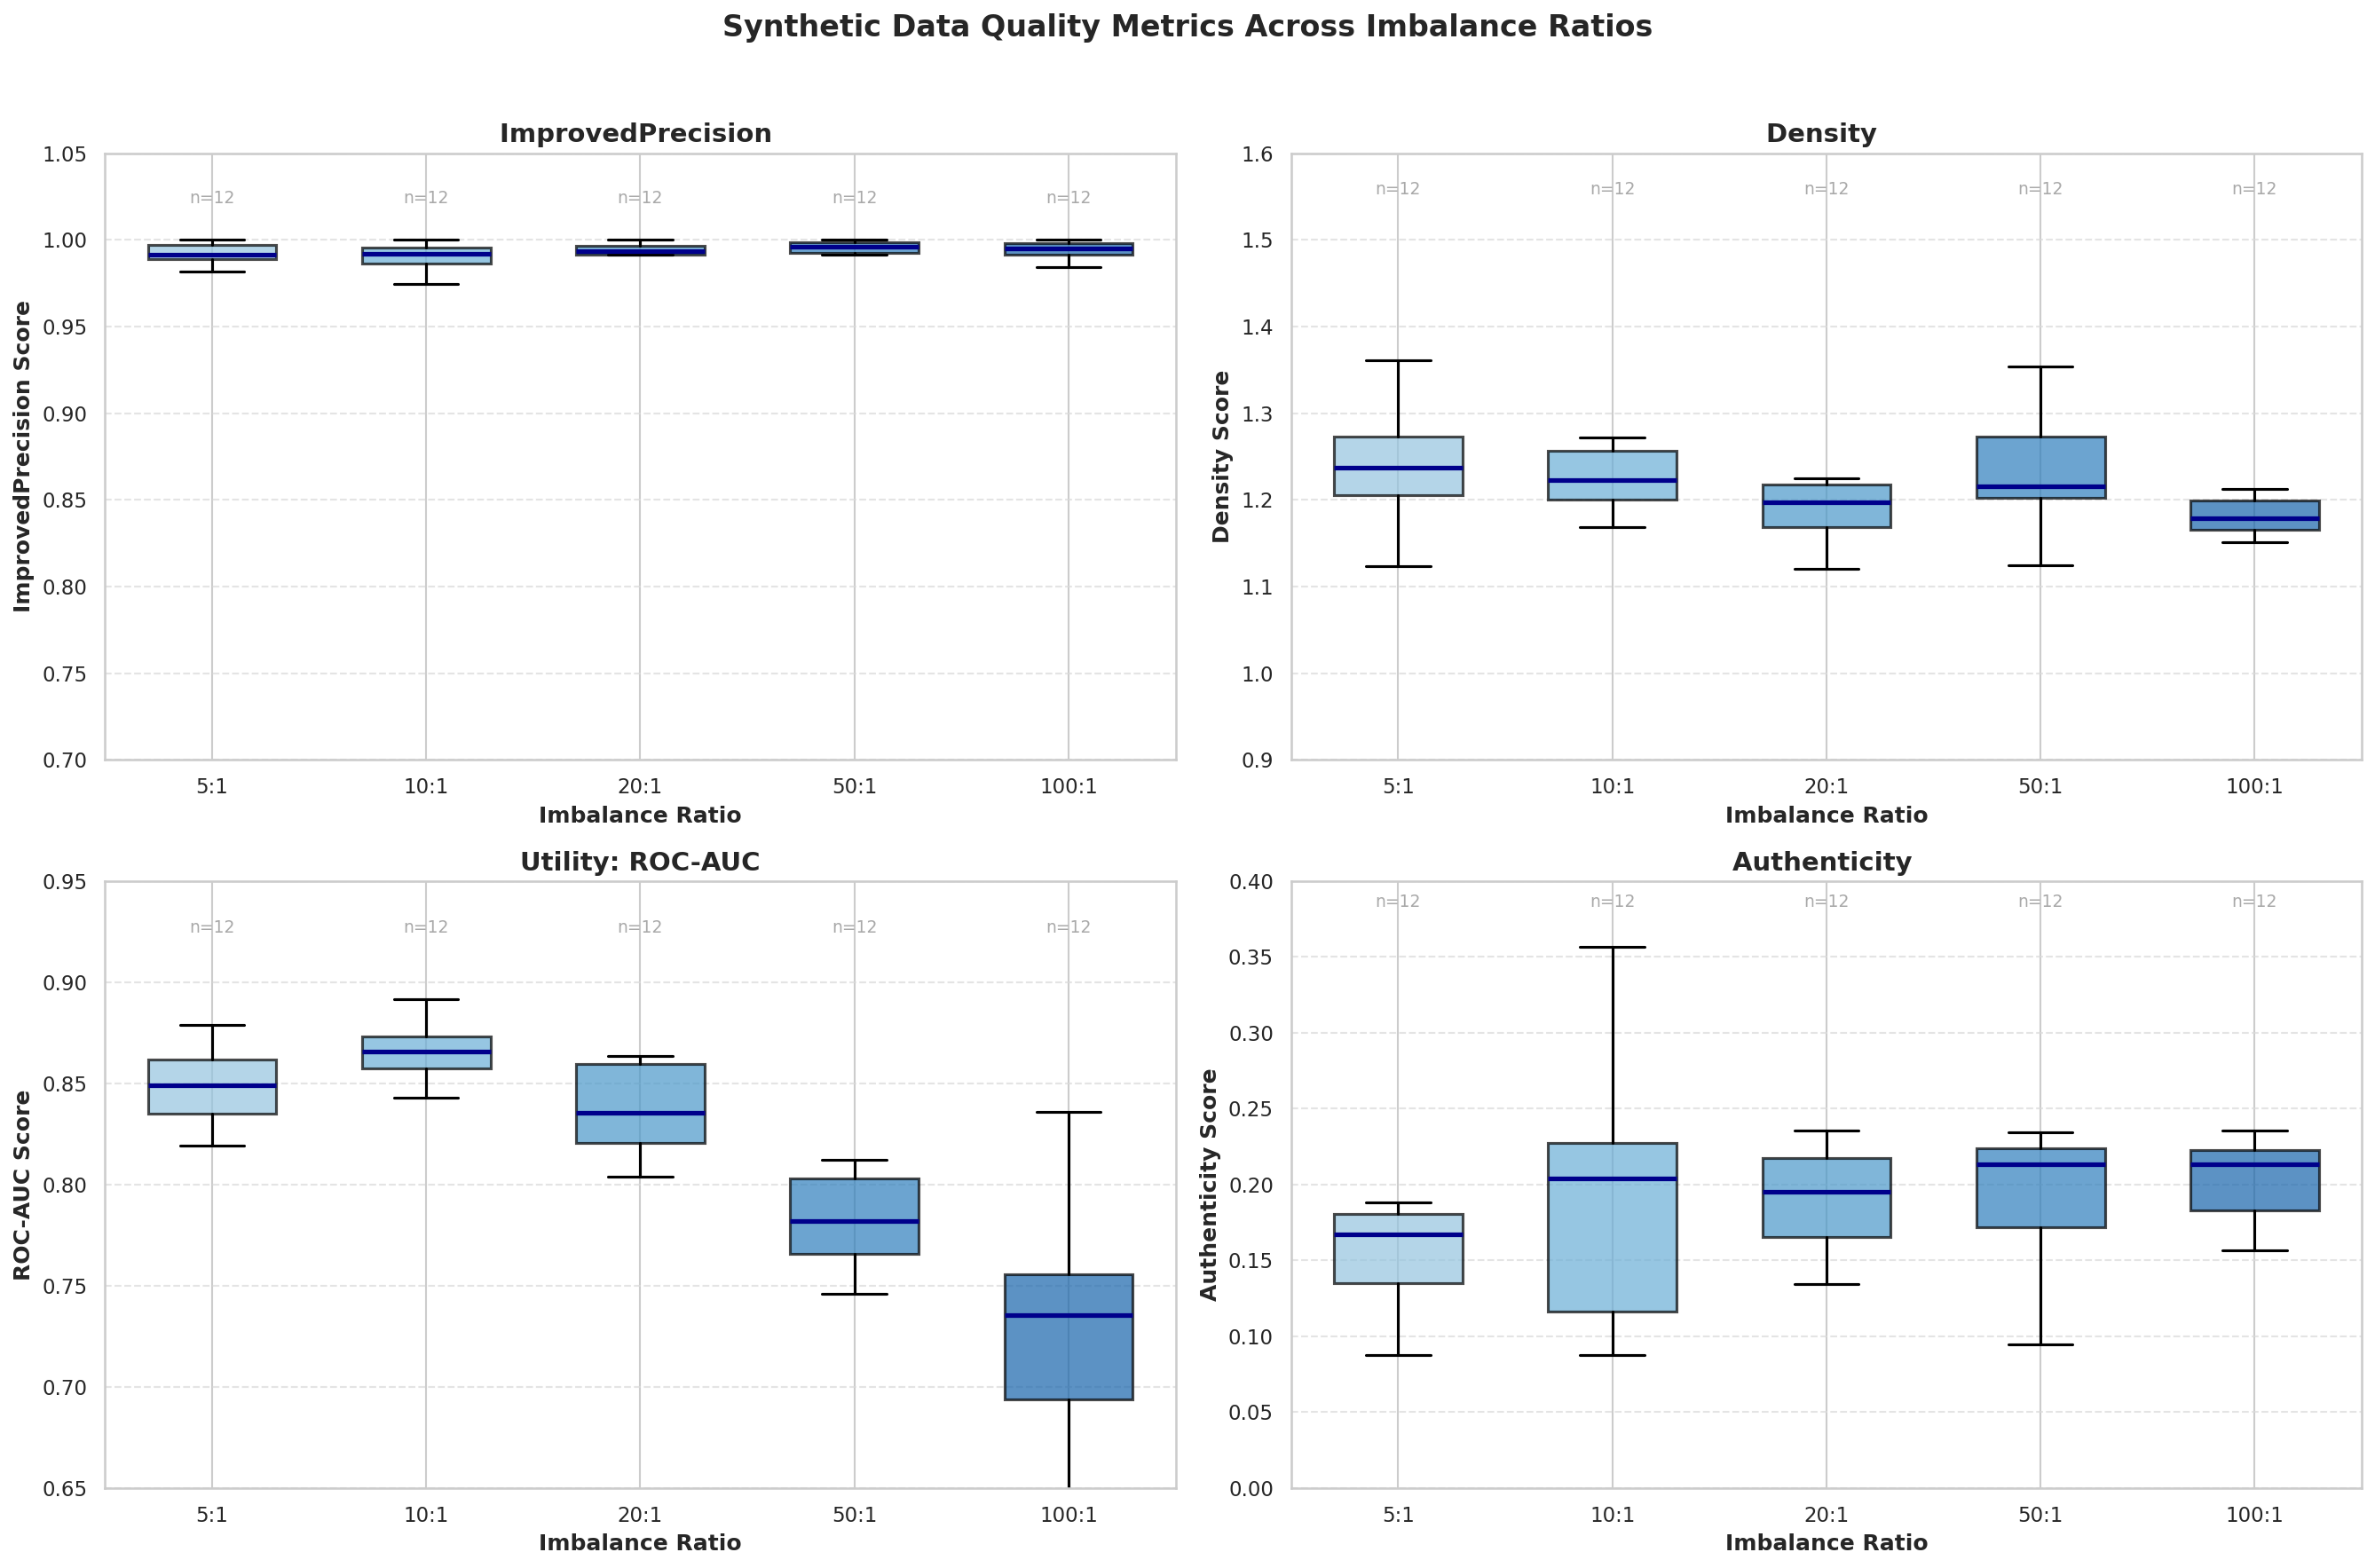

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Synthetic Data Quality Metrics Across Imbalance Ratios',
             fontsize=16, fontweight='bold')

plot_metric_boxplots_combined(raw_results_df, 'precision', axes[0, 0], 
                              'ImprovedPrecision ', 
                              'ImprovedPrecision Score', y_lim=(0.7, 1.05))

plot_metric_boxplots_combined(raw_results_df, 'density', axes[0, 1], 
                              'Density ', 
                              'Density Score', y_lim=(0.9, 1.6))

plot_metric_boxplots_combined(raw_results_df, 'roc_auc', axes[1, 0], 
                              'Utility: ROC-AUC', 
                              'ROC-AUC Score', y_lim=(0.65, 0.95))

plot_metric_boxplots_combined(raw_results_df, 'authenticity', axes[1, 1], 
                              'Authenticity ', 
                              'Authenticity Score', y_lim=(0, 0.4))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'overall_quality_distribution.png', dpi=300)
plt.show()

## 2.7 Multi-Dimensional Quality Profile (Radar Chart)

Visualizing the overall quality profile across all metrics simultaneously.

In [99]:
metrics_for_radar = ['precision', 'density', 'roc_auc', 'authenticity']
radar_df = results_df.copy()

for metric in metrics_for_radar:
    radar_df[metric] = radar_df[f"{metric}_mean"]

scaler = MinMaxScaler()
radar_df[metrics_for_radar] = scaler.fit_transform(radar_df[metrics_for_radar])

In [100]:
def plot_radar_chart(data, ir_level, ax):
    df_ir = data[data['ir'] == ir_level]
    labels = metrics_for_radar
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for gen, style in GENERATOR_STYLES.items():
        gen_data = df_ir[df_ir['generator'] == gen]
        if gen_data.empty:
            continue
            
        values = gen_data[labels].values.flatten().tolist()
        values += values[:1]
        
        ax.plot(angles, values, color=style['color'], linewidth=2, 
                linestyle=style['linestyle'], label=gen)
        ax.fill(angles, values, color=style['color'], alpha=0.25)

    ax.set_rlabel_position(180 / num_vars)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([l.replace('_', ' ').title() for l in labels], size=11)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f"IR = {ir_level}:1", size=14, weight='bold', position=(0.5, 1.1))

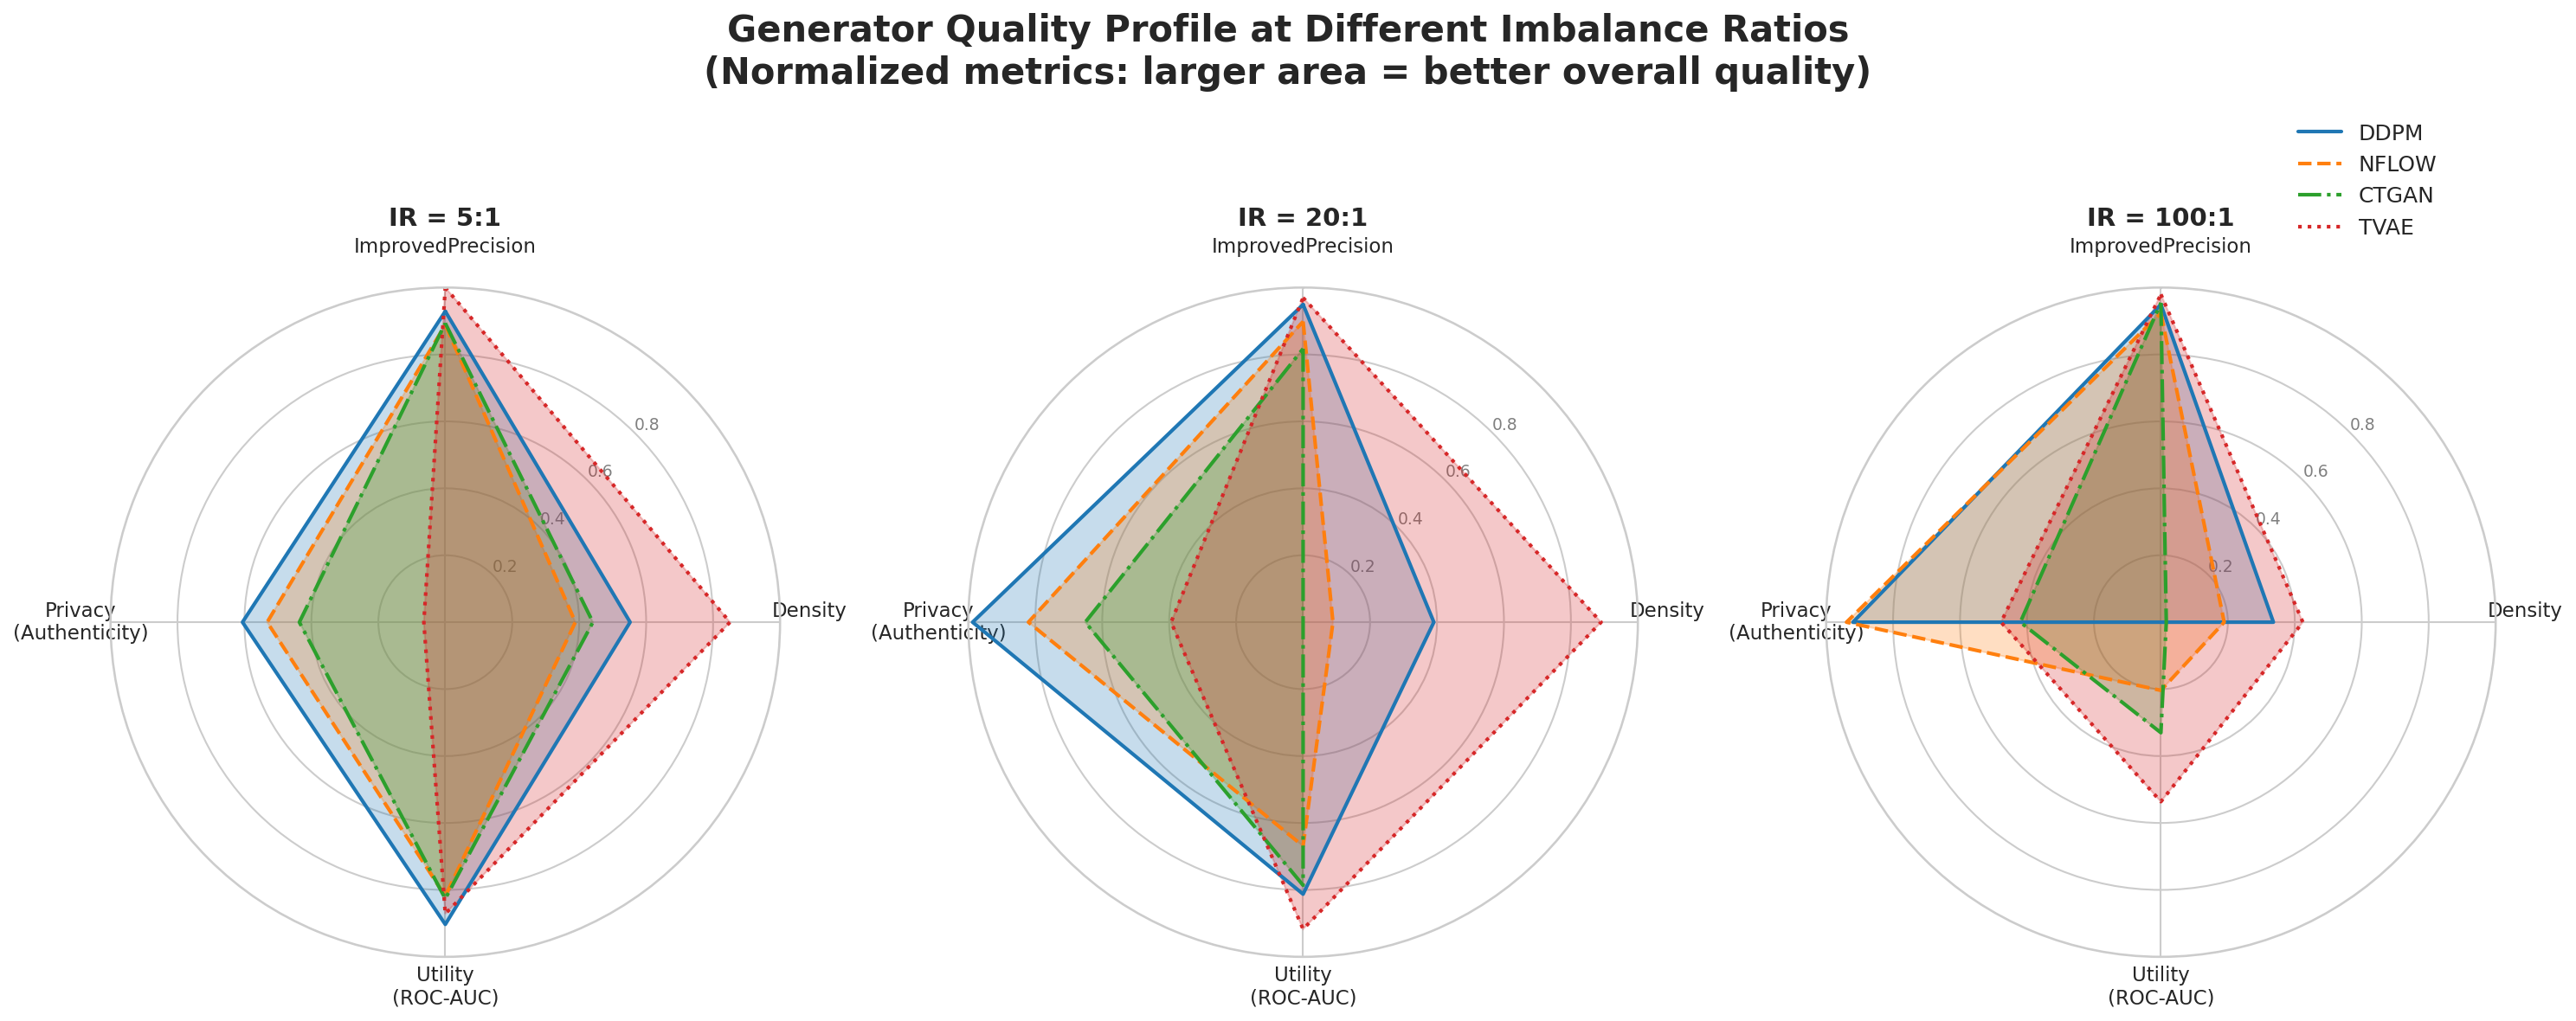

In [101]:
metrics_for_radar_improved = ['precision', 'density', 'roc_auc', 'authenticity']
radar_df_improved = results_df.copy()

radar_df_improved['precision'] = radar_df_improved['precision_mean']
radar_df_improved['density'] = radar_df_improved['density_mean']
radar_df_improved['roc_auc'] = radar_df_improved['roc_auc_mean']
radar_df_improved['authenticity'] = radar_df_improved['authenticity_mean']

scaler_improved = MinMaxScaler()
radar_df_improved[metrics_for_radar_improved] = scaler_improved.fit_transform(
    radar_df_improved[metrics_for_radar_improved]
)

def plot_radar_chart_improved(data, ir_level, ax, labels):
    df_ir = data[data['ir'] == ir_level]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for gen, style in GENERATOR_STYLES.items():
        gen_data = df_ir[df_ir['generator'] == gen]
        if gen_data.empty:
            continue

        values = gen_data[labels].values.flatten().tolist()
        values += values[:1]

        ax.plot(angles, values, color=style['color'], linewidth=2, 
                linestyle=style['linestyle'], label=gen)
        ax.fill(angles, values, color=style['color'], alpha=0.25)

    ax.set_rlabel_position(180 / num_vars)
    ax.set_xticks(angles[:-1])
    
    label_map = {
        'precision': 'ImprovedPrecision\n',
        'density': 'Density\n',
        'roc_auc': 'Utility\n(ROC-AUC)',
        'authenticity': 'Privacy\n(Authenticity)'
    }
    readable_labels = [label_map.get(l, l.title()) for l in labels]
    
    ax.set_xticklabels(readable_labels, size=11)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f"IR = {ir_level}:1", size=14, weight='bold', position=(0.5, 1.15)) 

fig, axes = plt.subplots(figsize=(20, 7), ncols=3, subplot_kw=dict(projection='polar')) 
fig.suptitle('Generator Quality Profile at Different Imbalance Ratios\n(Normalized metrics: larger area = better overall quality)', 
             fontsize=20, fontweight='bold', y=1.1) 

labels_for_plot = ['precision', 'density', 'roc_auc', 'authenticity']

plot_radar_chart_improved(radar_df_improved, 5, axes[0], labels_for_plot)
plot_radar_chart_improved(radar_df_improved, 20, axes[1], labels_for_plot)
plot_radar_chart_improved(radar_df_improved, 100, axes[2], labels_for_plot)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 1.0))

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'quality_radar_profiles_IMPROVED.png', dpi=300, bbox_inches='tight')
plt.show()


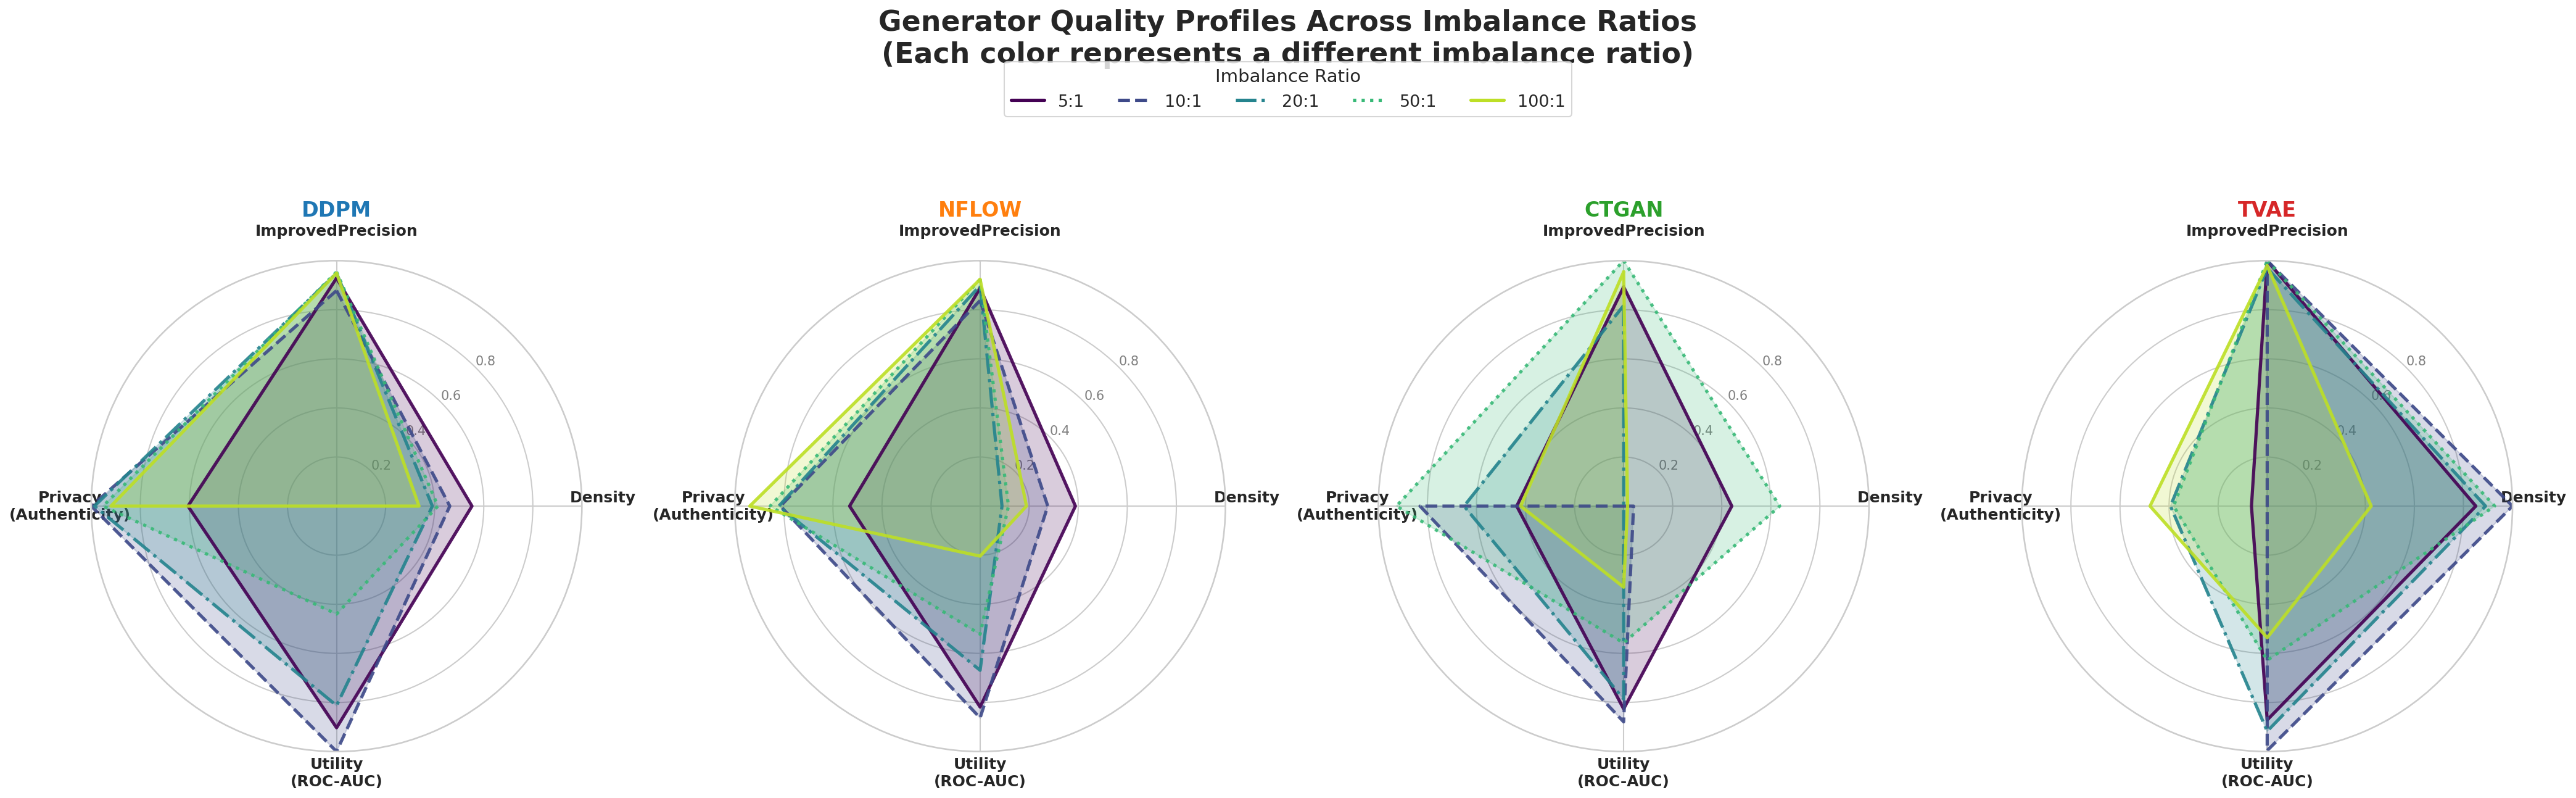

In [102]:
metrics_for_radar_by_gen = ['precision', 'density', 'roc_auc', 'authenticity']
radar_df_by_gen = results_df.copy()

radar_df_by_gen['precision'] = radar_df_by_gen['precision_mean']
radar_df_by_gen['density'] = radar_df_by_gen['density_mean']
radar_df_by_gen['roc_auc'] = radar_df_by_gen['roc_auc_mean']
radar_df_by_gen['authenticity'] = radar_df_by_gen['authenticity_mean']

scaler_by_gen = MinMaxScaler()
radar_df_by_gen[metrics_for_radar_by_gen] = scaler_by_gen.fit_transform(
    radar_df_by_gen[metrics_for_radar_by_gen]
)

ir_values = sorted(radar_df_by_gen['ir'].unique())
ir_colors = plt.cm.viridis(np.linspace(0, 0.9, len(ir_values)))
IR_STYLES = {
    ir: {"color": color, "linestyle": ["-", "--", "-.", ":"][i % 4]}
    for i, (ir, color) in enumerate(zip(ir_values, ir_colors))
}

def plot_radar_chart_by_generator(data, generator, ax, labels):
    """Plot radar chart for a specific generator with different IRs as different colors"""
    df_gen = data[data['generator'] == generator]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for ir, style in IR_STYLES.items():
        ir_data = df_gen[df_gen['ir'] == ir]
        if ir_data.empty:
            continue

        values = ir_data[labels].values.flatten().tolist()
        values += values[:1]

        ax.plot(angles, values, color=style['color'], linewidth=2.5, 
                linestyle=style['linestyle'], label=f'{ir}:1', alpha=0.9)
        ax.fill(angles, values, color=style['color'], alpha=0.2)

    ax.set_rlabel_position(180 / num_vars)
    ax.set_xticks(angles[:-1])
    
    label_map = {
        'precision': 'ImprovedPrecision\n',
        'density': 'Density\n',
        'roc_auc': 'Utility\n(ROC-AUC)',
        'authenticity': 'Privacy\n(Authenticity)'
    }
    readable_labels = [label_map.get(l, l.title()) for l in labels]
    
    ax.set_xticklabels(readable_labels, size=12, fontweight='bold')
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    ax.set_ylim(0, 1)
    ax.set_title(generator, size=16, weight='bold', position=(0.5, 1.15),
                color=GENERATOR_STYLES[generator]['color']) 

fig, axes = plt.subplots(figsize=(28, 8), ncols=4, nrows=1, subplot_kw=dict(projection='polar'))
fig.suptitle('Generator Quality Profiles Across Imbalance Ratios\n(Each color represents a different imbalance ratio)',
             fontsize=22, fontweight='bold', y=1.08)

labels_for_plot = ['precision', 'density', 'roc_auc', 'authenticity']

for idx, gen in enumerate(GENERATOR_STYLES.keys()):
    plot_radar_chart_by_generator(radar_df_by_gen, gen, axes[idx], labels_for_plot)

handles, labels = [], []
for ir, style in IR_STYLES.items():
    handles.append(plt.Line2D([0], [0], color=style['color'], linewidth=2.5, 
                             linestyle=style['linestyle'], label=f'{ir}:1'))
    labels.append(f'{ir}:1')

fig.legend(handles, labels, loc='upper center', fontsize=13, 
          bbox_to_anchor=(0.5, 1.02), ncol=len(ir_values),
          title='Imbalance Ratio', title_fontsize=14, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(FIGURES_PATH / 'quality_radar_profiles_by_generator.png', dpi=300, bbox_inches='tight')
plt.show()


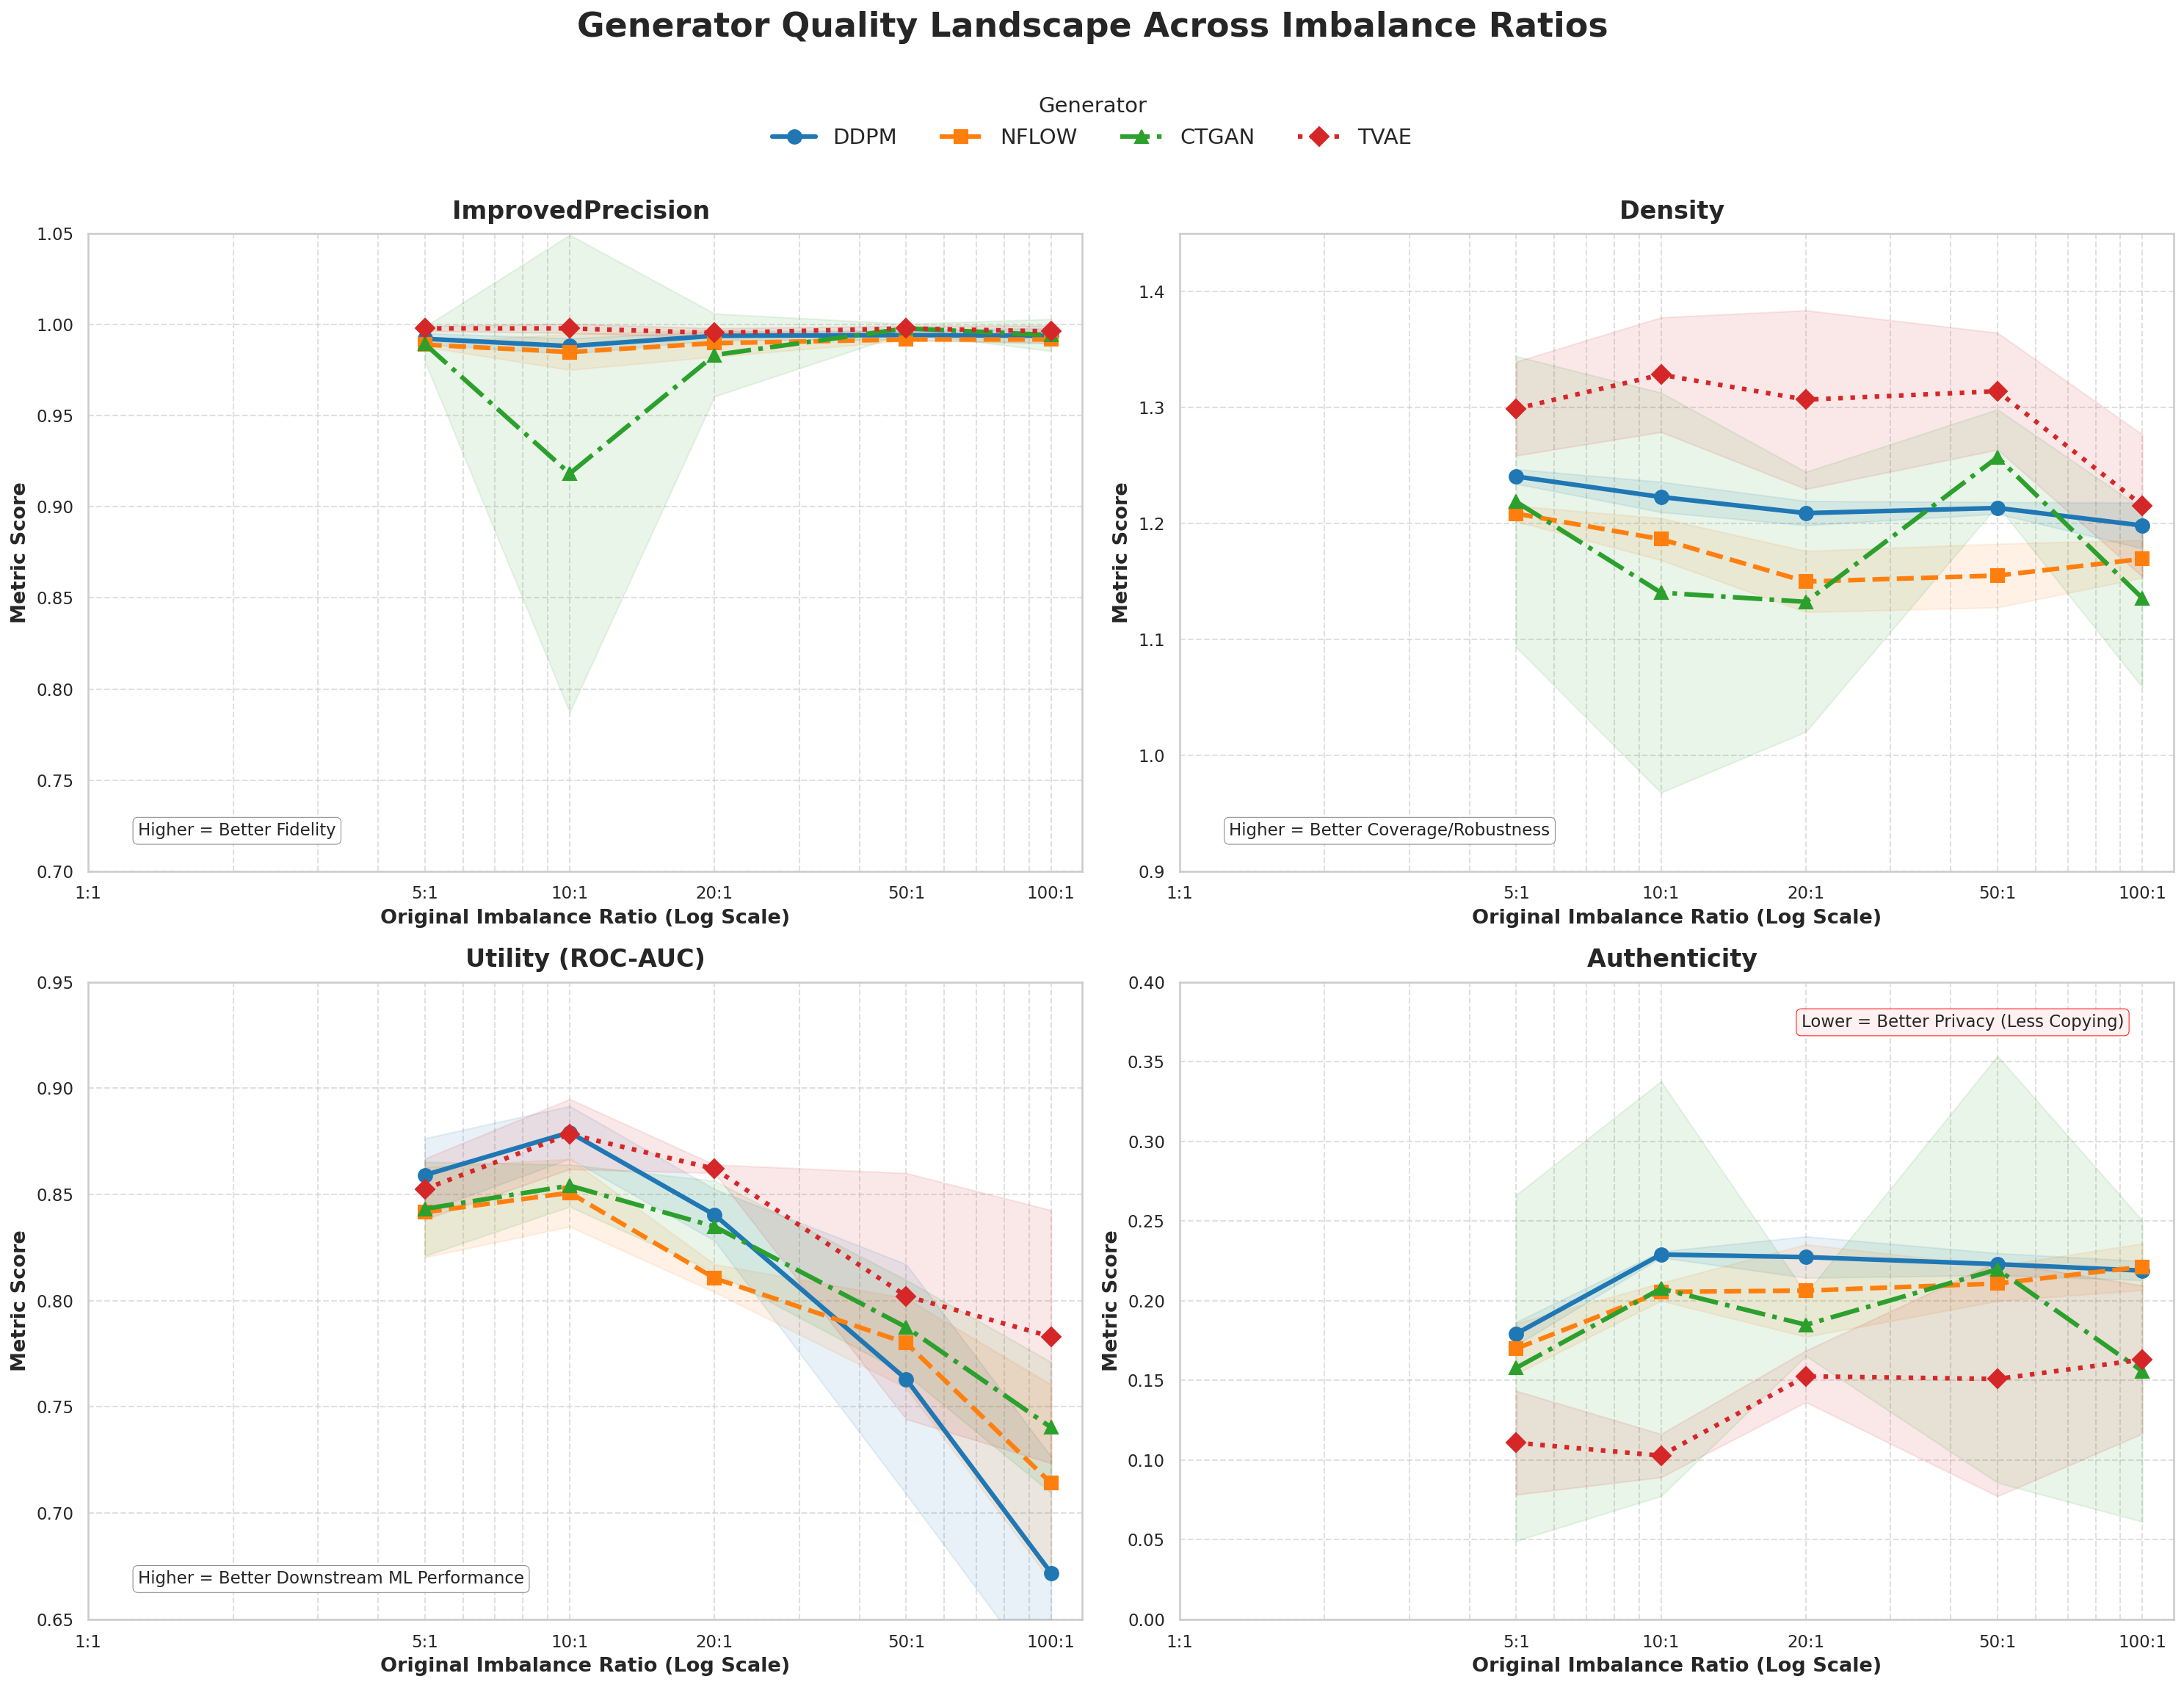

In [103]:
metrics_to_plot = [
    ('precision_mean', 'ImprovedPrecision ', (0.7, 1.05), "Higher = Better Fidelity"),
    ('density_mean', 'Density ', (0.9, 1.45), "Higher = Better Coverage/Robustness"),
    ('roc_auc_mean', 'Utility (ROC-AUC)', (0.65, 0.95), "Higher = Better Downstream ML Performance"),
    ('authenticity_mean', 'Authenticity ', (0, 0.4), "Lower = Better Privacy (Less Copying)")
]

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Generator Quality Landscape Across Imbalance Ratios',
             fontsize=22, fontweight='bold', y=1.02)

text_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.9)

for idx, (metric_col, title, y_lim, interpret_text) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for gen, style in GENERATOR_STYLES.items():
        gen_data = results_df[results_df['generator'] == gen]
        if gen_data.empty:
            continue
            
        metric_std_col = metric_col.replace('_mean', '_std')
        
        ax.plot(
            gen_data['ir'],
            gen_data[metric_col],
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            label=gen,
            markersize=9,
            linewidth=3,
            zorder=10
        )

        if metric_std_col in gen_data.columns:
            std_dev = gen_data[metric_std_col].fillna(0)
            ax.fill_between(
                gen_data['ir'],
                gen_data[metric_col] - std_dev,
                gen_data[metric_col] + std_dev,
                color=style['color'],
                alpha=0.1,
                zorder=5
            )

    ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
    ax.set_xlabel('Original Imbalance Ratio (Log Scale)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Metric Score', fontsize=13, fontweight='bold')
    ax.set_xscale('log')
    ax.set_xticks(IMBALANCE_RATIOS)
    ax.set_xticklabels([f"{ir}:1" for ir in IMBALANCE_RATIOS])
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    ax.grid(True, which="both", linestyle='--', alpha=0.6)

    if 'Authenticity' in title:
        text_props_privacy = text_props.copy()
        text_props_privacy['ec'] = 'red'
        text_props_privacy['fc'] = '#fff0f0'
        ax.text(0.95, 0.95, interpret_text, transform=ax.transAxes,
                fontsize=11, verticalalignment='top', horizontalalignment='right', 
                bbox=text_props_privacy, zorder=20)
    else:
        ax.text(0.05, 0.05, interpret_text, transform=ax.transAxes,
                fontsize=11, verticalalignment='bottom', horizontalalignment='left', 
                bbox=text_props, zorder=20)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.98), 
           ncol=len(GENERATORS), 
           fontsize=14, 
           title="Generator", 
           title_fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIGURES_PATH / 'improved_quality_landscape.png', dpi=300, bbox_inches='tight')
plt.show()

# Part 3: Integrated Analysis

## 3.1 Synthetic Dataset Imbalance Ratio Validation

Do the generative models successfully balance the training data as intended?

In [104]:
def analyze_imbalance_ratio(df, target_col='Severity'):
    value_counts = df[target_col].value_counts()
    if len(value_counts) < 2 or value_counts.min() == 0: 
        return {
            'imbalance_ratio': float('inf'), 
            'n_majority': value_counts.max() if len(value_counts) > 0 else len(df), 
            'n_minority': 0
        }
    
    majority = value_counts.max()
    minority = value_counts.min()
    return {
        'imbalance_ratio': round(majority / minority, 2) if minority > 0 else float('inf'),
        'n_majority': int(majority), 
        'n_minority': int(minority)
    }

ir_analysis_results = []

original_train_files = sorted(glob.glob(str(PROCESSED_PATH / "train_imbalanced_ir_*_rep*.csv")))
print(f"Found {len(original_train_files)} original training files")

for original_file in original_train_files:
    original_path = Path(original_file)
    original_df = pd.read_csv(original_path)
    
    match = re.search(r'ir_(\d+)_rep(\d+)', original_path.name)
    if not match:
        continue
    ir_value, rep_id = map(int, match.groups())

    original_analysis = analyze_imbalance_ratio(original_df)

    for generator in SYNTHETIC_MODELS:
        synth_filename = f"{original_path.stem}_balanced_by_{generator}.csv"
        synth_path = SYNTHETIC_PATH / synth_filename
        
        if not synth_path.exists(): 
            continue
        
        synthetic_df = pd.read_csv(synth_path)
        synthetic_analysis = analyze_imbalance_ratio(synthetic_df)
        
        entry = {
            'original_ir': ir_value,
            'generator': generator,
            'run': rep_id,
            'original_n_maj': original_analysis['n_majority'],
            'original_n_min': original_analysis['n_minority'],
            'final_n_maj': synthetic_analysis['n_majority'],
            'final_n_min': synthetic_analysis['n_minority'],
            'achieved_ir': synthetic_analysis['imbalance_ratio']
        }
        ir_analysis_results.append(entry)

if ir_analysis_results:
    ir_comparison_df = pd.DataFrame(ir_analysis_results)
    ir_summary_df = ir_comparison_df.groupby(['original_ir', 'generator']).agg(
        mean_final_n_maj=('final_n_maj', 'mean'),
        mean_final_n_min=('final_n_min', 'mean'),
        mean_achieved_ir=('achieved_ir', 'mean'),
        std_achieved_ir=('achieved_ir', 'std')
    ).reset_index()
else:
    print("\nWARNING: No synthetic data files were found. Plots will be empty.")
    ir_comparison_df = pd.DataFrame()
    ir_summary_df = pd.DataFrame(columns=['original_ir', 'generator', 'mean_final_n_maj', 
                                          'mean_final_n_min', 'mean_achieved_ir', 'std_achieved_ir'])

Found 18 original training files


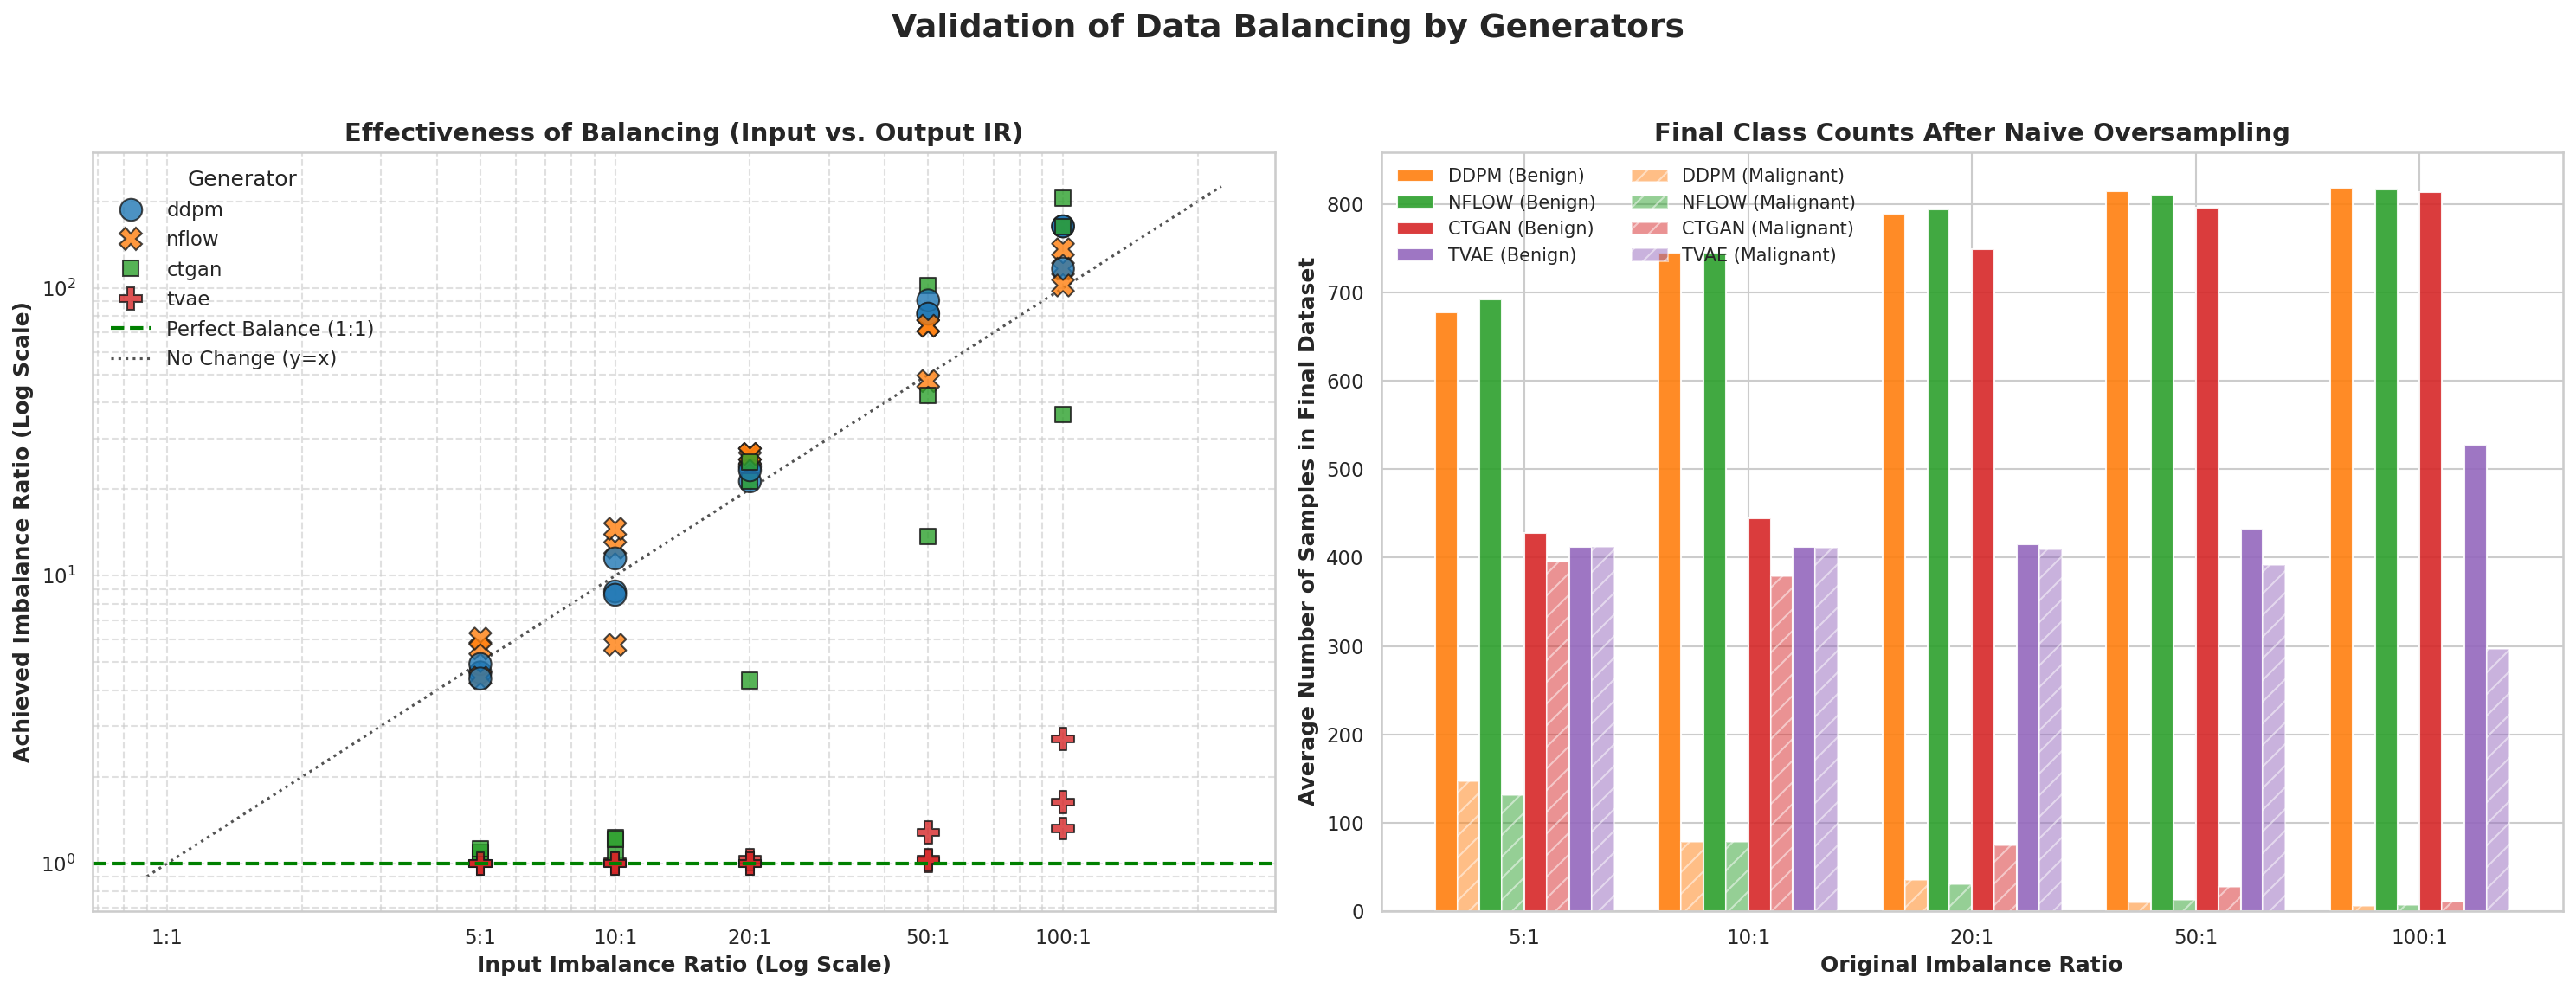

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Validation of Data Balancing by Generators', fontsize=18, fontweight='bold')

# Plot 1: Input vs. Output Imbalance Ratio (Scatter Plot)
ax = axes[0]
if not ir_comparison_df.empty:
    sns.scatterplot(data=ir_comparison_df, x='original_ir', y='achieved_ir',
                    hue='generator', style='generator',
                    ax=ax, s=150, alpha=0.8, edgecolor='k',
                    palette=PALETTE)

    ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Perfect Balance (1:1)')

    lims = np.array([
        min(ir_comparison_df['original_ir'].min(), ir_comparison_df['achieved_ir'].min()),
        max(ir_comparison_df['original_ir'].max(), ir_comparison_df['achieved_ir'].max())
    ])
    lims = [lims[0] * 0.9, lims[1] * 1.1]
    ax.plot(lims, lims, 'k:', alpha=0.75, zorder=0, label='No Change (y=x)')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Input Imbalance Ratio (Log Scale)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Achieved Imbalance Ratio (Log Scale)', fontsize=12, fontweight='bold')
    ax.set_title('Effectiveness of Balancing (Input vs. Output IR)', fontsize=14, fontweight='bold')
    ax.set_xticks([1, 5, 10, 20, 50, 100])
    ax.set_xticklabels([f'{ir}:1' for ir in [1, 5, 10, 20, 50, 100]])
    ax.legend(title='Generator')
    ax.grid(True, which="both", linestyle='--', alpha=0.6)

# Plot 2: Final Class Counts
ax = axes[1]
if not ir_summary_df.empty:
    n_irs = len(ir_summary_df['original_ir'].unique())
    n_gens = len(SYNTHETIC_MODELS)
    x = np.arange(n_irs)
    width = 0.8 / n_gens
    x_labels = [f'{ir}:1' for ir in sorted(ir_summary_df['original_ir'].unique())]

    for i, generator in enumerate(SYNTHETIC_MODELS):
        gen_data = ir_summary_df[ir_summary_df['generator'] == generator]
        offset = width * (i - (n_gens - 1) / 2)
        
        # Benign (majority) bars
        ax.bar(x + offset - width/4, gen_data['mean_final_n_maj'], width/2, 
               label=f'{generator.upper()} (Benign)', 
               color=MODEL_COLORS.get(generator, '#cccccc'), alpha=0.9)
        
        # Malignant (minority) bars
        ax.bar(x + offset + width/4, gen_data['mean_final_n_min'], width/2, 
               label=f'{generator.upper()} (Malignant)', 
               color=MODEL_COLORS.get(generator, '#cccccc'), alpha=0.5, hatch='//')

    ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Number of Samples in Final Dataset', fontsize=12, fontweight='bold')
    ax.set_title('Final Class Counts After Naive Oversampling', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    legend_elements = [
        Patch(facecolor=MODEL_COLORS.get(gen, '#cccccc'), label=f'{gen.upper()} (Benign)', alpha=0.9) 
        for gen in SYNTHETIC_MODELS
    ] + [
        Patch(facecolor=MODEL_COLORS.get(gen, '#cccccc'), label=f'{gen.upper()} (Malignant)', alpha=0.5, hatch='//') 
        for gen in SYNTHETIC_MODELS
    ]
    ax.legend(handles=legend_elements, ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'imbalance_ratio_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.2 Ridge Plots: Distribution Evolution Across Imbalance Ratios

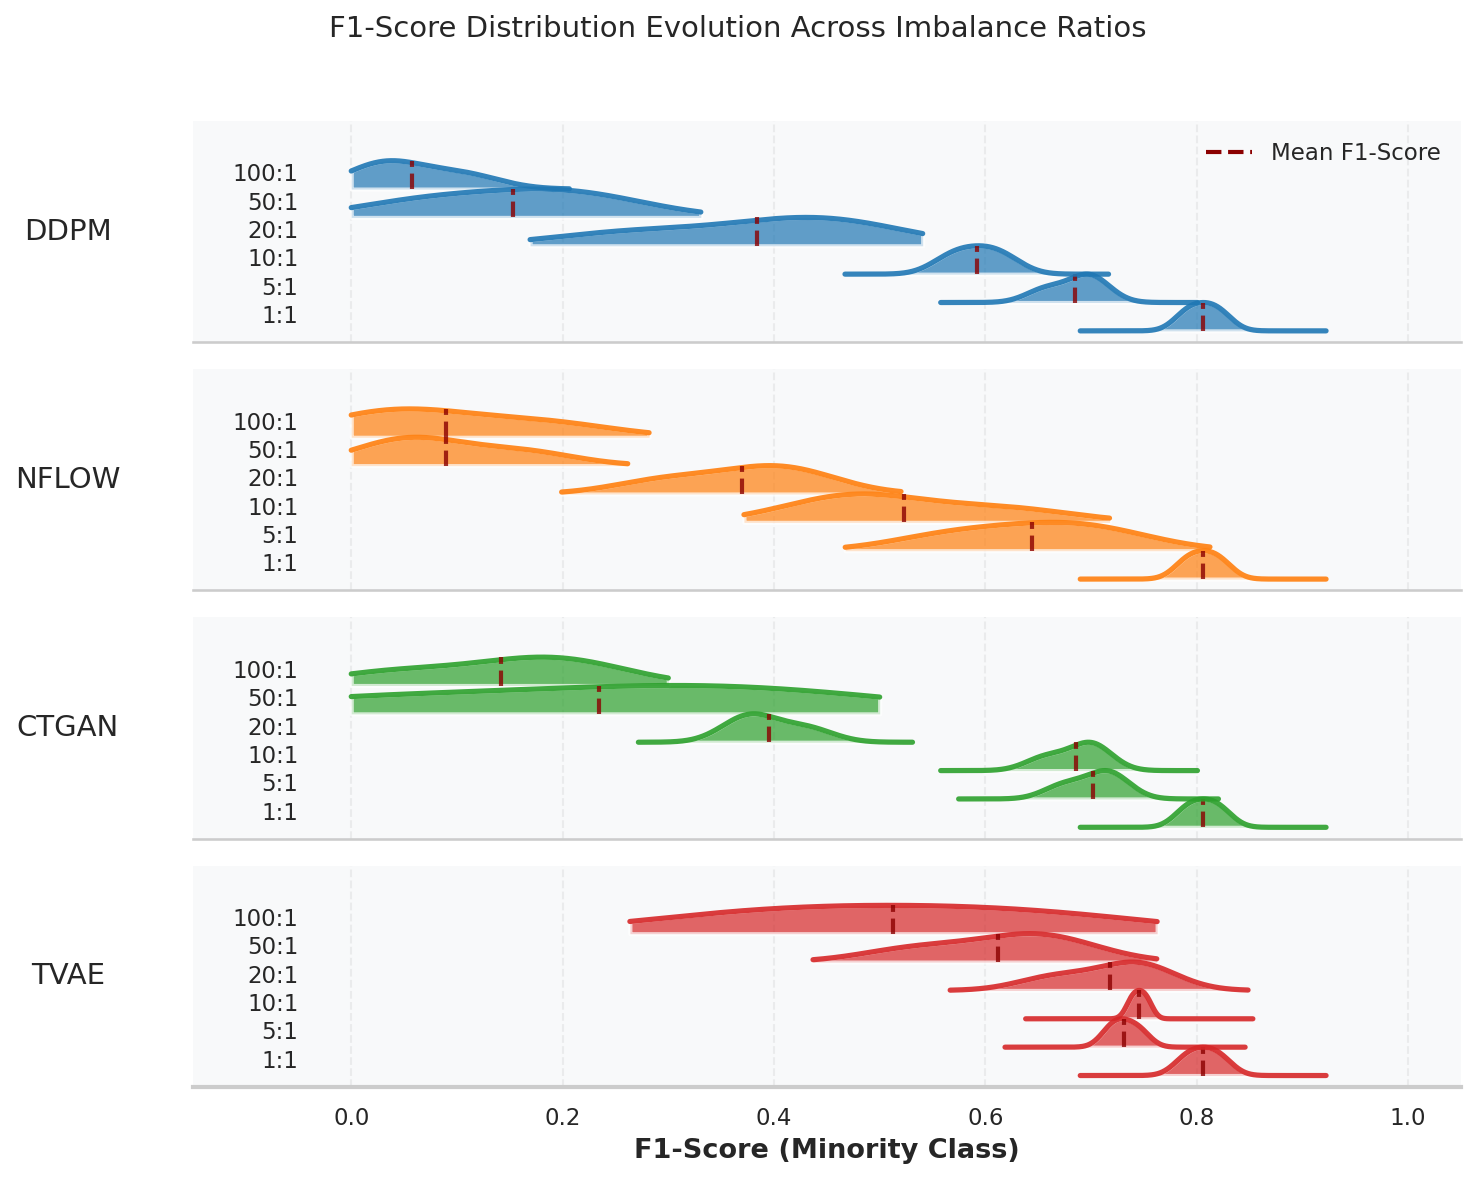

In [106]:
ridge_data = detailed_df[detailed_df['dataset_type'] == 'imbalanced'].copy()

fig, axes = plt.subplots(len(GENERATORS), 1, figsize=(10, 8), sharex=True)
fig.suptitle('F1-Score Distribution Evolution Across Imbalance Ratios',
             fontsize=14)

ir_levels = sorted(ridge_data['ir_numeric'].unique())
overlap = 0.5  

for gen_idx, generator in enumerate(GENERATORS):
    ax = axes[gen_idx]
    gen_data = ridge_data[ridge_data['model'] == generator]
    
    if gen_data.empty:
        continue
    
    for ir_idx, ir in enumerate(ir_levels):
        ir_data = gen_data[gen_data['ir_numeric'] == ir]['f1_minority'].values
        
        if len(ir_data) < 2:
            continue
        
        try:
            kde = gaussian_kde(ir_data, bw_method='scott')
            x_range = np.linspace(max(0, ir_data.min() - 0.1), 
                                 min(1, ir_data.max() + 0.1), 500)
            density = kde(x_range)
            
            density = density / density.max() * overlap
            y_offset = ir_idx * (1 - overlap)
            
            ax.fill_between(x_range, y_offset, y_offset + density,
                           alpha=0.7, color=GENERATOR_STYLES[generator.upper()]['color'],
                           edgecolor='white', linewidth=2)
            
            ax.plot(x_range, y_offset + density, 
                   color=GENERATOR_STYLES[generator.upper()]['color'],
                   linewidth=2.5, alpha=0.9)
            
            ax.text(-0.05, y_offset + overlap/2, f'{ir}:1',
                   fontsize=11, va='center', ha='right')
            
            mean_val = ir_data.mean()
            ax.plot([mean_val, mean_val], [y_offset, y_offset + overlap],
                   color='darkred', linewidth=2, linestyle='--', alpha=0.8)
            
        except Exception as e:
            continue
    
    ax.set_ylabel(generator.upper(), fontsize=14, rotation=0,
                 labelpad=60, va='center')
    ax.set_ylim(-0.2, len(ir_levels) * (1 - overlap) + overlap + 0.2)
    ax.set_xlim(-0.15, 1.05)
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    ax.set_facecolor('#f8f9fa')

axes[-1].set_xlabel('F1-Score (Minority Class)', fontsize=13, fontweight='bold')
axes[-1].spines['bottom'].set_linewidth(2)

legend_elements = [Line2D([0], [0], color='darkred', linewidth=2, 
                         linestyle='--', label='Mean F1-Score')]
axes[0].legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'ridge_plot_distribution_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

Plot saved to ../results/figures/slope_graph_critical_transitions.png


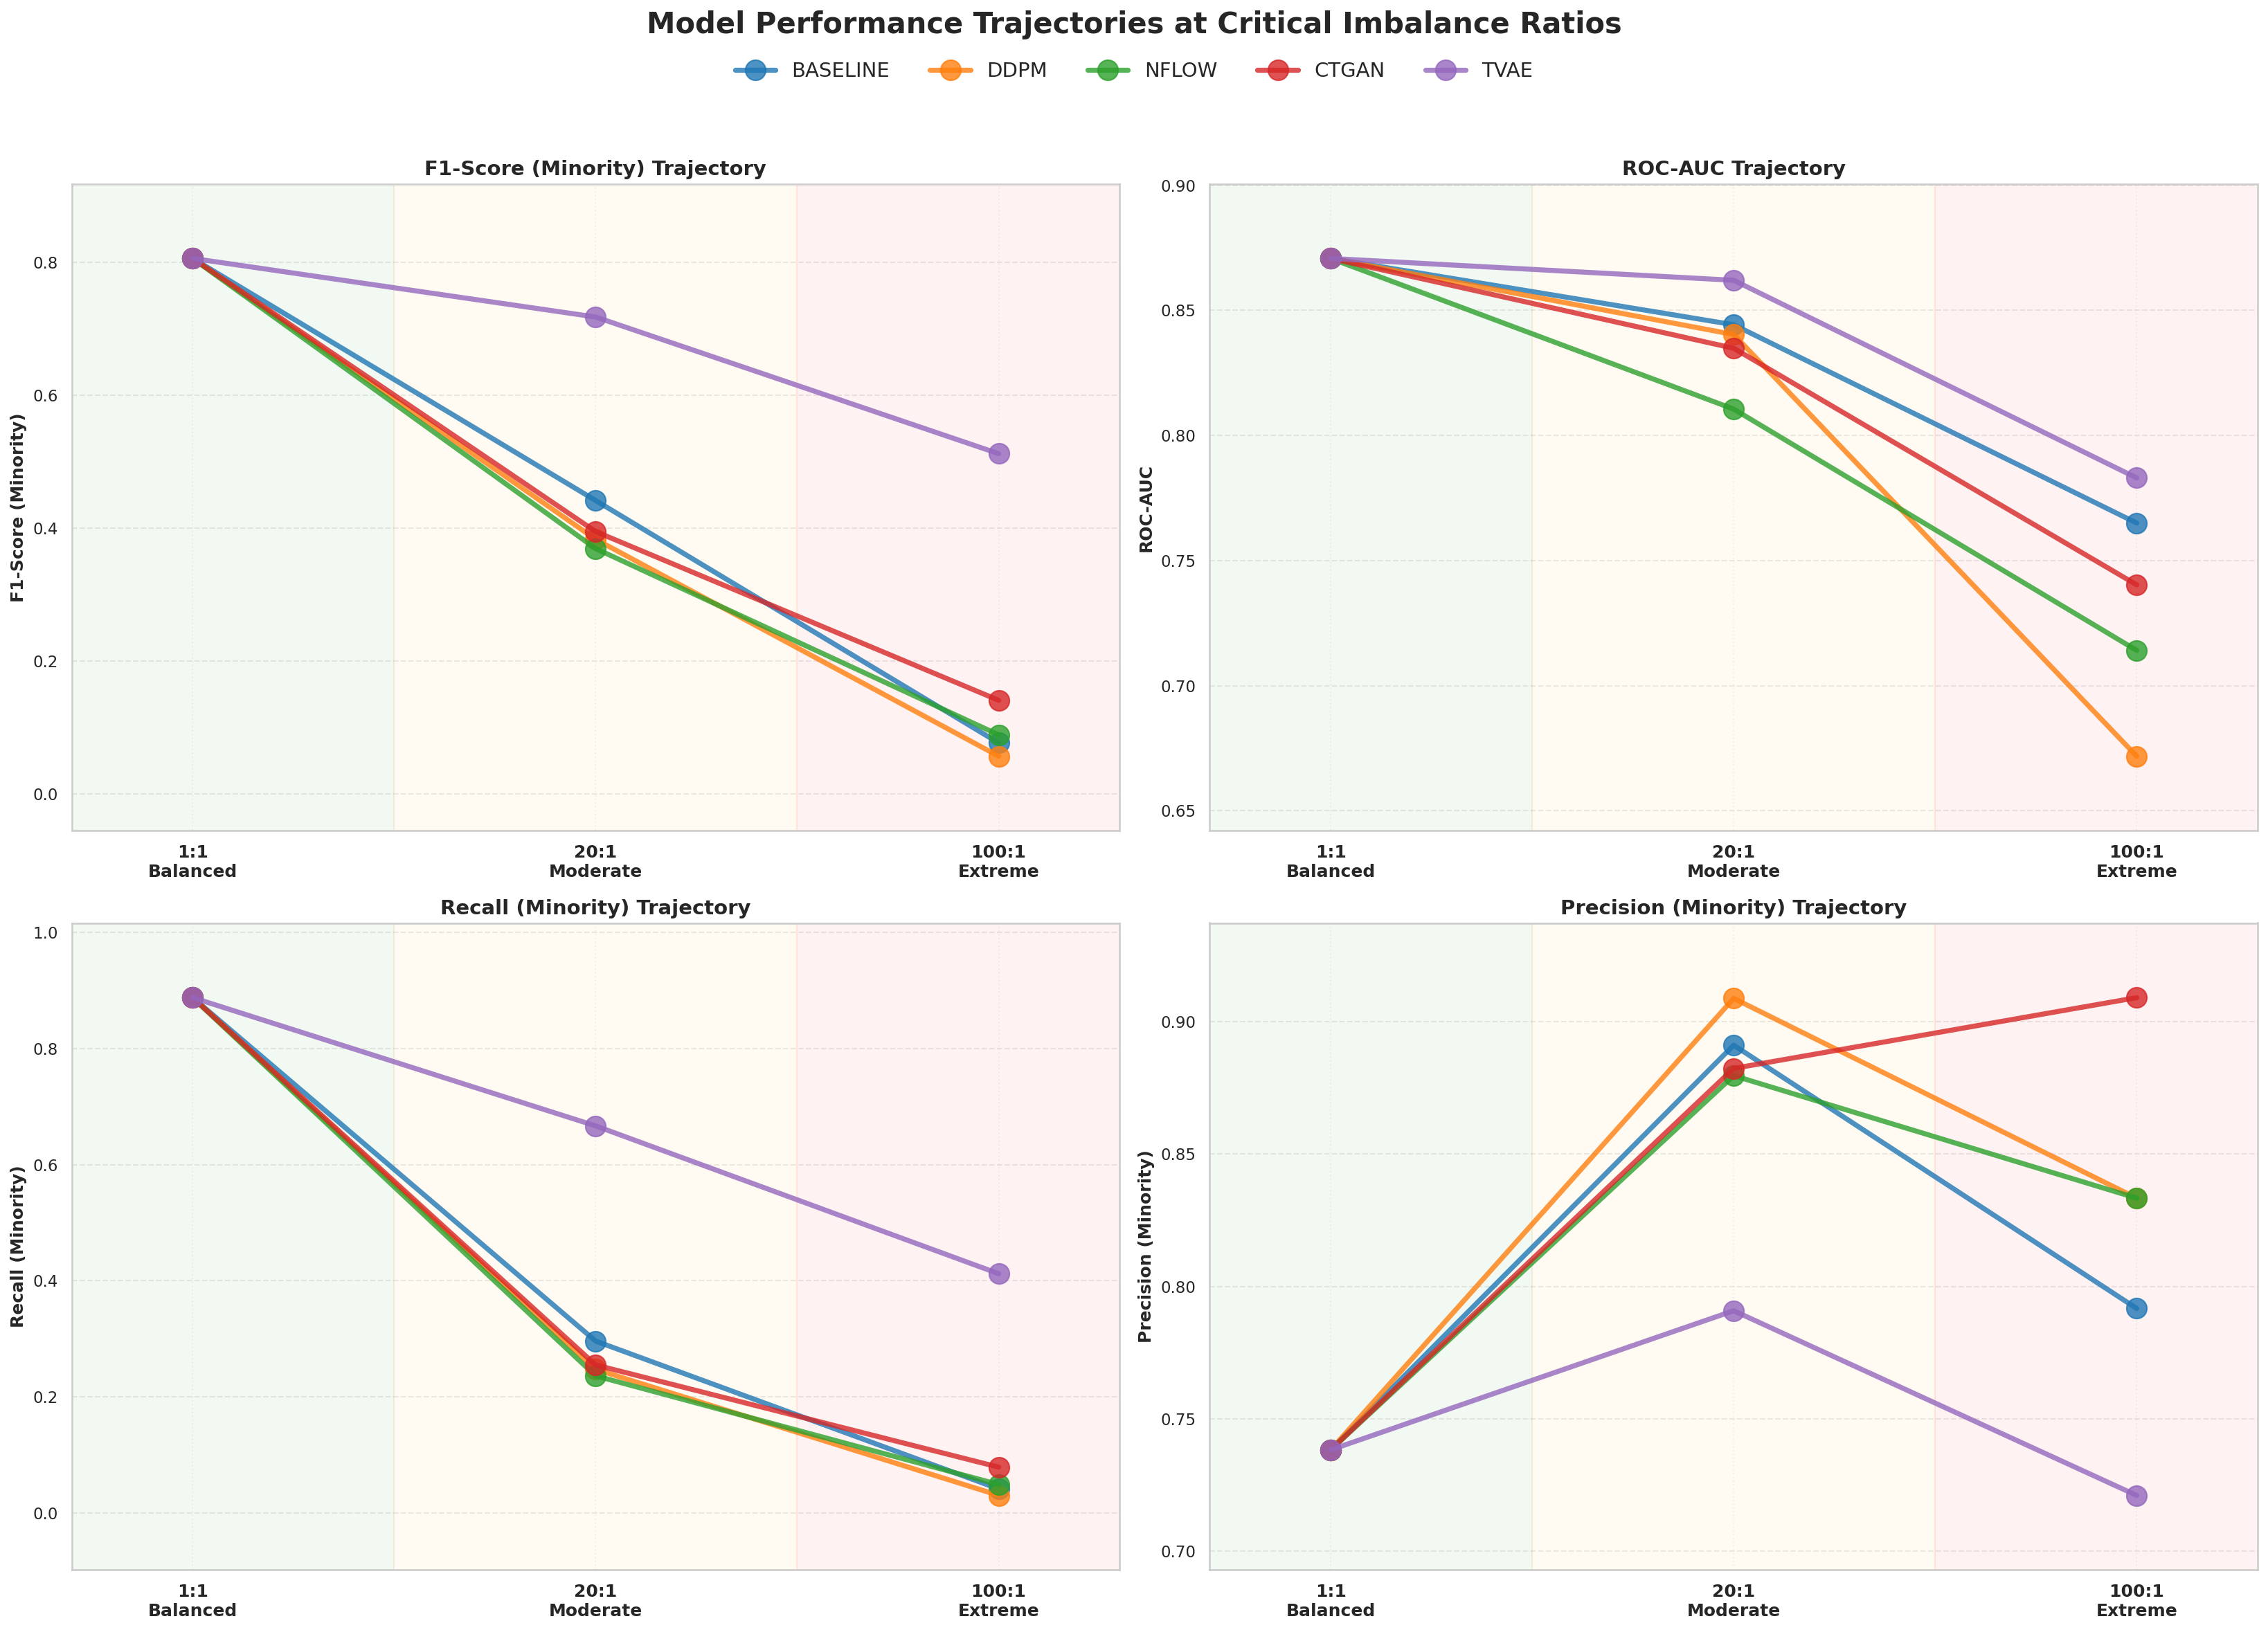

In [107]:
critical_irs = [1, 20, 100]
slope_data = summary_df[
    (summary_df['dataset_type'] == 'imbalanced') &
    (summary_df['ir_numeric'].isin(critical_irs))
].copy()

metrics_for_slope = [
    ('f1_minority_mean', 'F1-Score (Minority)'),
    ('roc_auc_mean', 'ROC-AUC'),
    ('recall_minority_mean', 'Recall (Minority)'),
    ('precision_minority_mean', 'Precision (Minority)')
]

fig, axes = plt.subplots(2, 2, figsize=(22, 16))

fig.suptitle('Model Performance Trajectories at Critical Imbalance Ratios',
             fontsize=20, fontweight='bold')

for idx, (metric_col, metric_name) in enumerate(metrics_for_slope):
    ax = axes[idx // 2, idx % 2]

    for model in MODELS_TO_ANALYZE: 
        model_data = slope_data[slope_data['model'] == model].sort_values('ir_numeric')

        if len(model_data) < 2:
            print(f"Skipping {model} for {metric_name}: not enough data points.")
            continue

        x_positions = np.arange(len(critical_irs))
        y_values = []

        for ir in critical_irs:
            ir_value = model_data[model_data['ir_numeric'] == ir][metric_col]
            if len(ir_value) > 0:
                y_values.append(ir_value.values[0])
            else:
                y_values.append(np.nan)

        if all(np.isnan(y_values)):
            print(f"Skipping {model} for {metric_name}: all data is NaN.")
            continue
            
        ax.plot(x_positions, y_values,
               marker='o', linewidth=3.5, markersize=14,
               color=MODEL_COLORS.get(model, 'gray'),
               alpha=0.8,
               label=model.upper(), zorder=10)

    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'{ir}:1\n{"Balanced" if ir == 1 else "Moderate" if ir == 20 else "Extreme"}'
                        for ir in critical_irs], fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_name} Trajectory', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.grid(True, axis='x', linestyle=':', alpha=0.2)
    ax.set_xlim(-0.3, len(critical_irs) - 0.7)

    ax.axvspan(-0.5, 0.5, alpha=0.05, color='green', label='_nolegend_')
    ax.axvspan(0.5, 1.5, alpha=0.05, color='orange', label='_nolegend_')
    ax.axvspan(1.5, 2.5, alpha=0.05, color='red', label='_nolegend_')

    valid_data = slope_data[metric_col].dropna()
    if not valid_data.empty:
        y_min = valid_data.min()
        y_max = valid_data.max()
        y_range = y_max - y_min
        if y_range > 0:
             ax.set_ylim(y_min - y_range * 0.15, y_max + y_range * 0.15)
        else:
            ax.set_ylim(y_min - 0.1, y_max + 0.1)
    else:
        ax.set_ylim(0, 1) 

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles: 
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, 0.96),
               ncol=len(MODELS_TO_ANALYZE), 
               fontsize=14,
               frameon=False) 
else:
    print("Warning: No data was plotted, legend will be empty.")

plt.tight_layout(rect=[0, 0, 1, 0.93]) 

save_path = FIGURES_PATH / 'slope_graph_critical_transitions.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {save_path}")
plt.show()

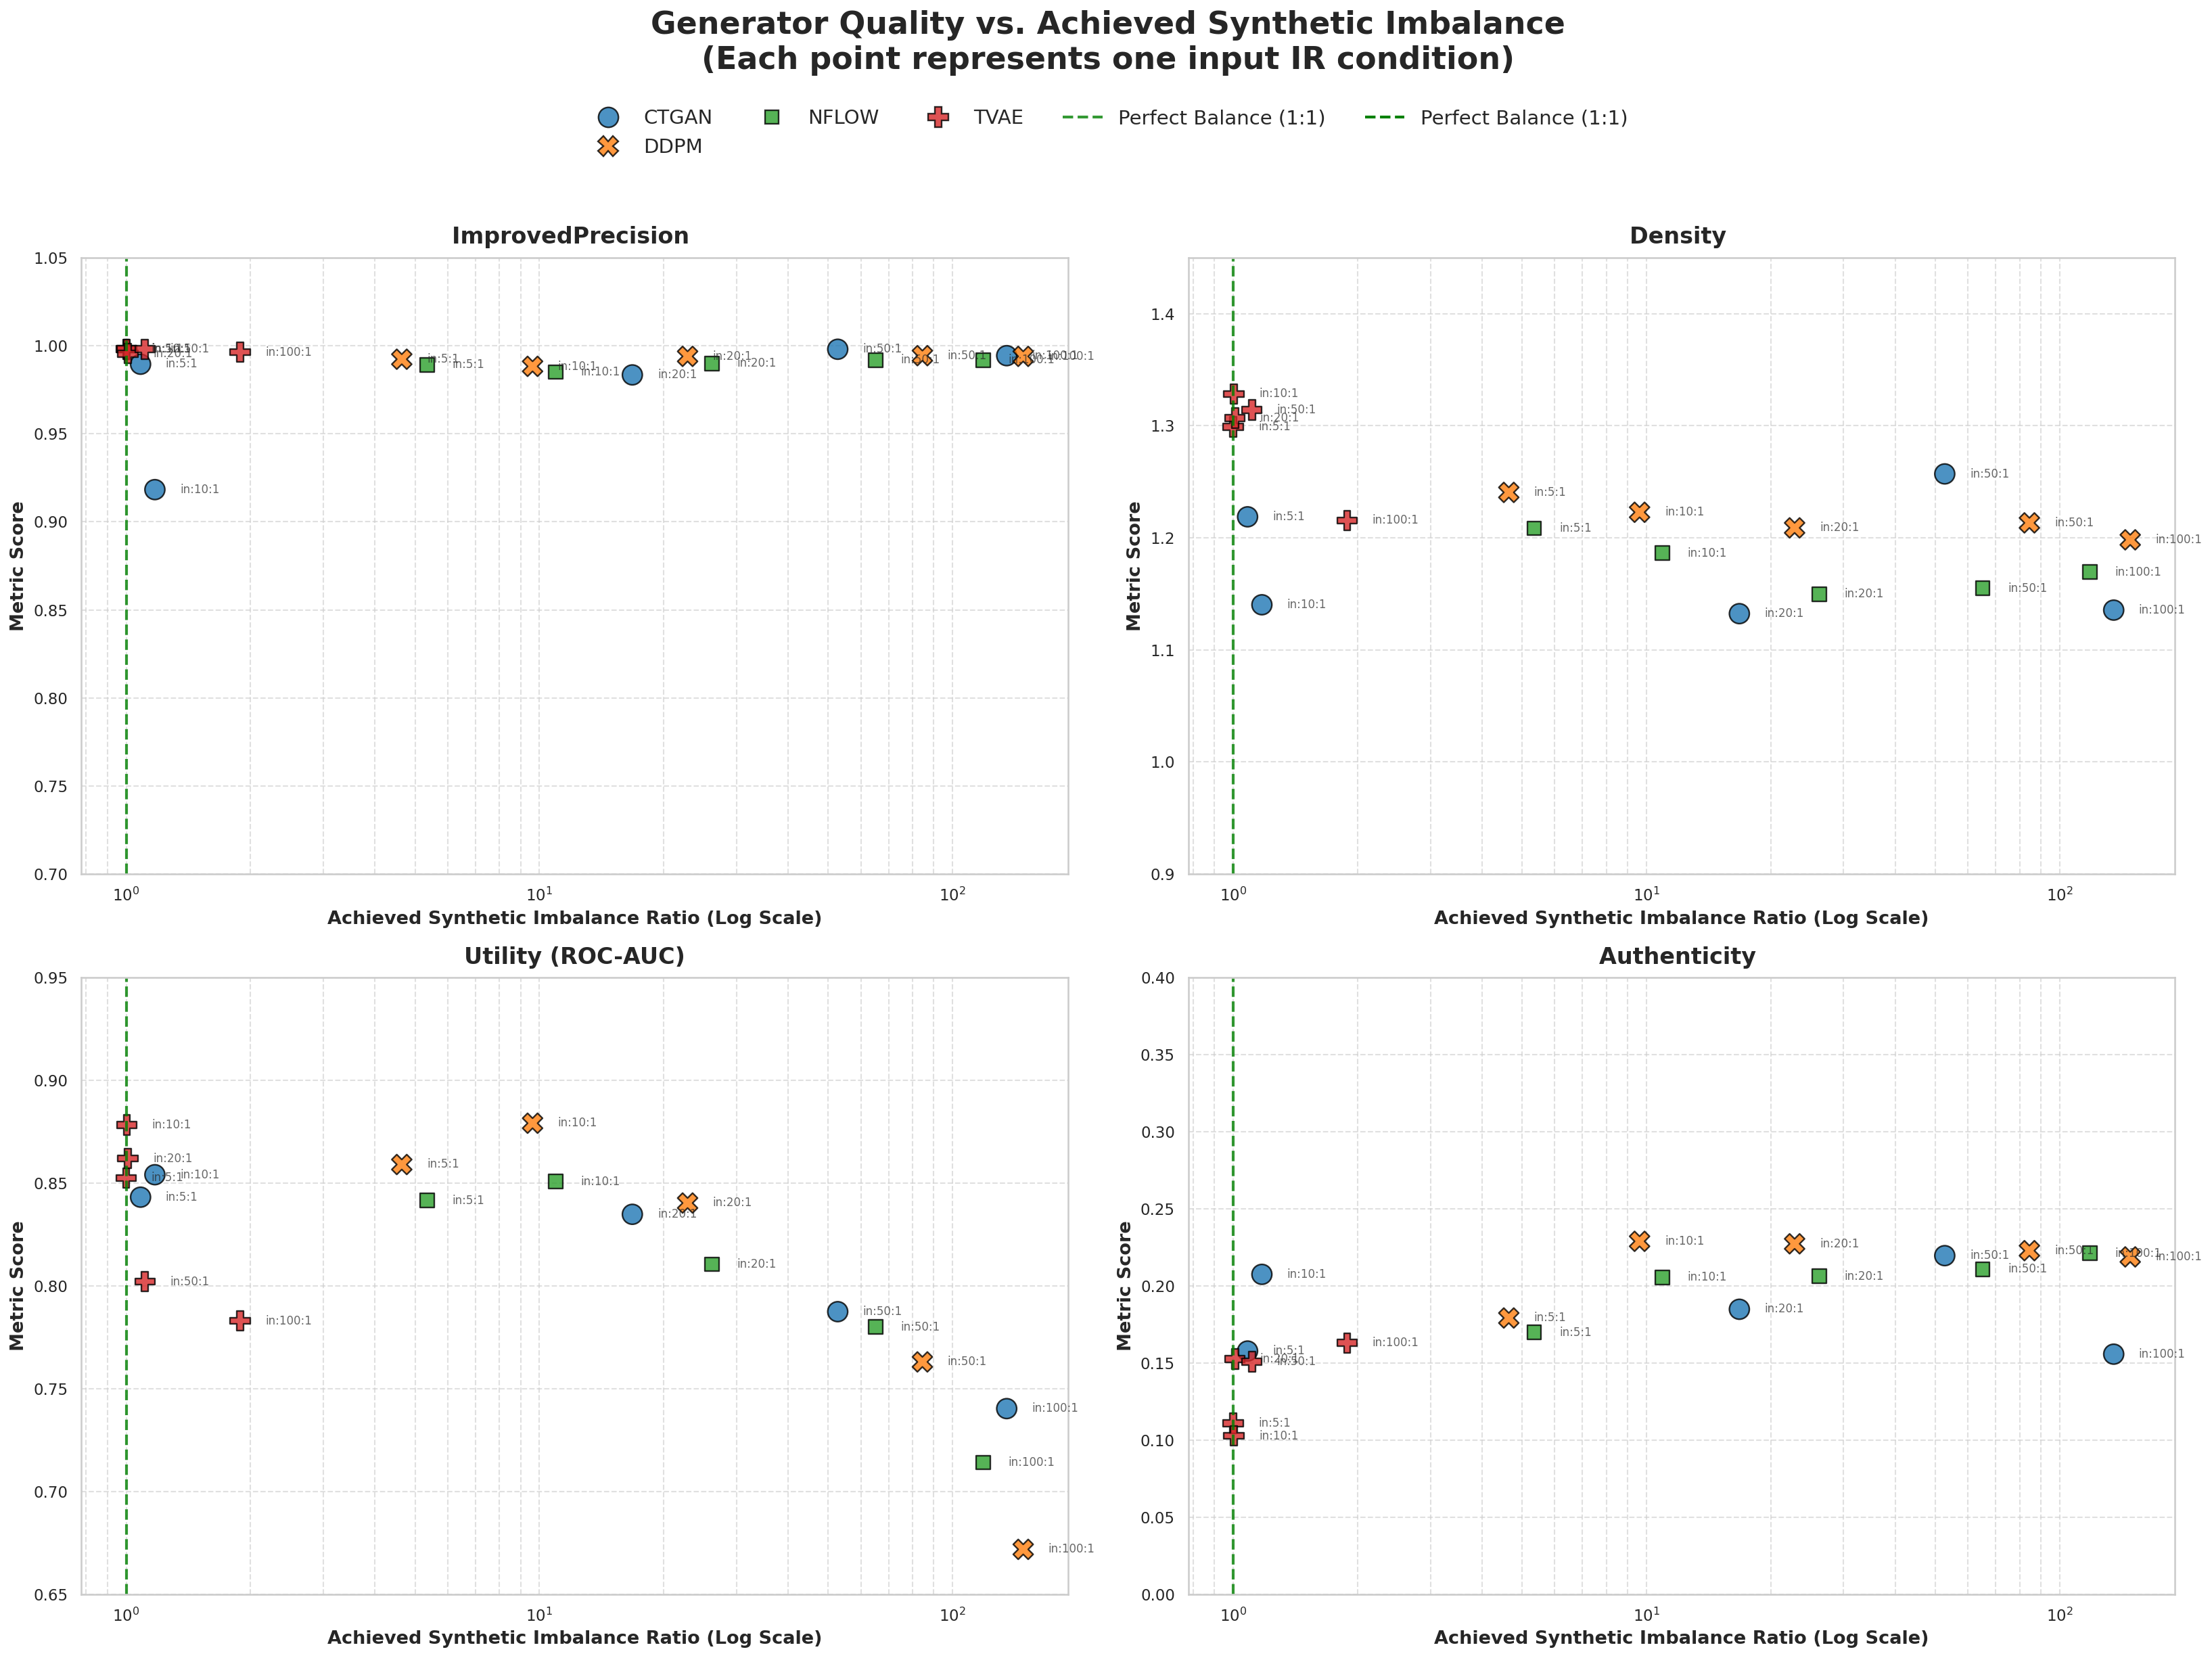

In [108]:
if 'generator' in ir_summary_df.columns:
    ir_summary_df['generator'] = ir_summary_df['generator'].str.upper()

merged_results_df = pd.merge(
    results_df,
    ir_summary_df[['original_ir', 'generator', 'mean_achieved_ir']],
    left_on=['ir', 'generator'],
    right_on=['original_ir', 'generator']
).drop(columns=['original_ir'])

metrics_to_plot = [
    ('precision_mean', 'ImprovedPrecision ', (0.7, 1.05)),
    ('density_mean', 'Density ', (0.9, 1.45)),
    ('roc_auc_mean', 'Utility (ROC-AUC)', (0.65, 0.95)),
    ('authenticity_mean', 'Authenticity ', (0, 0.4))
]

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle('Generator Quality vs. Achieved Synthetic Imbalance\n(Each point represents one input IR condition)',
             fontsize=22, fontweight='bold', y=1.02)

if not merged_results_df.empty:
    for idx, (metric_col, title, y_lim) in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        sns.scatterplot(
            data=merged_results_df,
            x='mean_achieved_ir',
            y=metric_col,
            hue='generator',
            style='generator',
            palette=PALETTE,
            s=200, 
            alpha=0.8,
            edgecolor='black',
            ax=ax
        )
        
        for _, row in merged_results_df.iterrows():
            ax.text(row['mean_achieved_ir'] * 1.15, row[metric_col], f"in:{row['ir']}:1", 
                    fontsize=8, ha='left', va='center', alpha=0.7)

        ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
        ax.set_xlabel('Achieved Synthetic Imbalance Ratio (Log Scale)', fontsize=13, fontweight='bold')
        ax.set_ylabel('Metric Score', fontsize=13, fontweight='bold')
        ax.set_xscale('log')
        ax.axvline(x=1, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Perfect Balance (1:1)')
        
        if y_lim:
            ax.set_ylim(y_lim)
            
        ax.grid(True, which="both", linestyle='--', alpha=0.6)
        ax.legend().set_visible(False) 

    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2))
    labels.append('Perfect Balance (1:1)')

    fig.legend(handles, labels, 
               loc='upper center', 
               bbox_to_anchor=(0.5, 0.97), 
               ncol=len(GENERATORS) + 1, 
               fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(FIGURES_PATH / 'quality_vs_achieved_ir_scatterplot.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("O gráfico não foi gerado porque o DataFrame de dados combinados está vazio.")